In [ ]:
## Run this once to install dependencies when resetting kernel
#%pip install geopandas
#%pip install geoplot
#%pip install causalinference==0.1.2
#%pip install statsmodels

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as spy
import statsmodels.api as sm
import geopandas as gpd
import geoplot as gplt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
## HERE IS IMPORTANT STYLE Params
# how to plot the map
ESPG = "EPSG:3857"
# map color gradient
MAPCOLOR = "YlOrRd"

In [ ]:
# Load the shp file with state geometry
geoData = gpd.read_file("GLM_Non_Parametric/cb_2022_us_state_500k.shp")
# Remove American Samoa, DC, and other territories. Last two entries are Hawaii and Alaska
# To include Hawaii('15') and Alaska('02') We need seperare inlaid graphs...
badFips = ["60", "11", "72", "78", "69", "66", "15", "02"]
geoData = geoData.drop(geoData[geoData.STATEFP.isin(badFips)].index)
geoData.crs = ESPG

In [ ]:
data = pd.read_csv("GLM_Non_Parametric/U.S._Chronic_Disease_Indicators_20240329.csv")

# EDA for GLM Analysis

In [ ]:
oral_data = data[data.Topic == "Oral Health"]

In [ ]:
oral_data.Question.unique()

array(['All teeth lost among adults aged 65 years and older',
       'Visited dentist or dental clinic in the past year among adults',
       'Receipt of evidence-based preventive dental services in the past 12 months among children and adolescents aged 1-17 years',
       'Visited dentist or other oral health care provider in the past 12 months among children and adolescents aged 1-17 years',
       'Preventive dental care in the 12 months before pregnancy among women with a recent live birth',
       'No teeth lost among adults aged 18-64 years',
       'Six or more teeth lost among adults aged 65 years and older'],
      dtype=object)

In [ ]:
## All these funcs assume you have a valid topic and question. Work ONLY on CDC data
def filterTopic(data, topic):
    #Hyunji's data cleaning
    this_data = data[data.Topic.str.contains(topic, na=False)]
    # Remove rows with missing or non-numeric 'DataValue'
    this_data = this_data[pd.to_numeric(this_data.DataValue, errors='coerce').notna()]
    # Convert 'DataValue' to float
    this_data.DataValue = this_data.DataValue.astype(float)
    this_data.reset_index(drop=True, inplace=True)
    # selects only important columns, feel free to add new columns
    return this_data[["YearStart", "YearEnd", "LocationAbbr", "DataSource", "Topic", "Question", "DataValueUnit", "DataValue", "DataValueType", "StratificationID1"]]

def filterQuestion(filteredOnTopic, question):
    filteredOnQuestion = filteredOnTopic[filteredOnTopic.Question == question]
    # Removes any territories
    badAbbr = ["GU", "DC", "US", "PR", "VI"]
    filteredOnQuestion = filteredOnQuestion.drop(filteredOnQuestion[filteredOnQuestion.LocationAbbr.isin(badAbbr)].index)
    filteredOnQuestion = filteredOnQuestion[(filteredOnQuestion.DataValueType == "Age-adjusted Prevalence") & (filteredOnQuestion.StratificationID1 == "OVR")]
    filteredOnQuestion  = sortSimple(filteredOnQuestion)
    filteredOnQuestion.reset_index(drop=True, inplace=True)
    return filteredOnQuestion

def filterTopicAndQuestion(data, topic, question):
    filteredOnTopic = filterTopic(data, topic)
    return filterQuestion(filteredOnTopic, question)

def sortSimple(df):
    return df.sort_values(by = ["YearStart", "LocationAbbr"])

In [ ]:
cdi_oral = filterTopic(data, "Oral Health")
cdi_oral.head()

,YearStart,YearEnd,LocationAbbr,DataSource,Topic,Question,DataValueUnit,DataValue,DataValueType,StratificationID1
0,2020,2020,US,BRFSS,Oral Health,All teeth lost among adults aged 65 years and ...,%,13.3,Crude Prevalence,SEXF
1,2020,2020,US,BRFSS,Oral Health,Visited dentist or dental clinic in the past y...,%,61.9,Crude Prevalence,SEXM
2,2018,2019,MT,NSCH,Oral Health,Receipt of evidence-based preventive dental se...,%,69.8,Crude Prevalence,AGE6_11
3,2018,2019,NY,NSCH,Oral Health,Receipt of evidence-based preventive dental se...,%,40.8,Crude Prevalence,OVR
4,2018,2019,GA,NSCH,Oral Health,Receipt of evidence-based preventive dental se...,%,44.7,Crude Prevalence,OVR


In [ ]:
data.Topic.unique()

array(['Disability', 'Arthritis', 'Immunization', 'Diabetes',
       'Health Status', 'Alcohol', 'Asthma', 'Sleep', 'Oral Health',
       'Mental Health', 'Cardiovascular Disease', 'Cancer', 'Tobacco',
       'Nutrition, Physical Activity, and Weight Status',
       'Chronic Obstructive Pulmonary Disease',
       'Social Determinants of Health', 'Cognitive Health and Caregiving',
       'Maternal Health', 'Chronic Kidney Disease'], dtype=object)

In [ ]:
cdi_tobacco = filterTopic(data, "Tobacco")
cdi_sleep = filterTopic(data, "Sleep")
cdi_nutrition = filterTopic(data, "Nutrition, Physical Activity, and Weight Status")

In [ ]:
cdi_nutrition.Question.unique()

array(['Children and adolescents aged 6-13 years meeting aerobic physical activity guideline',
       'Consumed regular soda at least one time daily among high school students',
       'No leisure-time physical activity among adults',
       'Obesity among adults',
       'Consumed vegetables less than one time daily among high school students',
       'Consumed fruit less than one time daily among high school students',
       'Met aerobic physical activity guideline for substantial health benefits, adults',
       'Met aerobic physical activity guideline among high school students',
       'Obesity among high school students',
       'Consumed fruit less than one time daily among adults',
       'Consumed vegetables less than one time daily among adults',
       'Infants who were exclusively breastfed through 6 months',
       'Infants who were breastfed at 12 months',
       'Obesity among WIC children aged 2 to 4 years'], dtype=object)

In [ ]:
cdi_dentist = filterQuestion(cdi_oral, "Visited dentist or dental clinic in the past year among adults")
cdi_dentist.head(10)

,YearStart,YearEnd,LocationAbbr,DataSource,Topic,Question,DataValueUnit,DataValue,DataValueType,StratificationID1
0,2020,2020,AK,BRFSS,Oral Health,Visited dentist or dental clinic in the past y...,%,62.6,Age-adjusted Prevalence,OVR
1,2020,2020,AL,BRFSS,Oral Health,Visited dentist or dental clinic in the past y...,%,61.3,Age-adjusted Prevalence,OVR
2,2020,2020,AR,BRFSS,Oral Health,Visited dentist or dental clinic in the past y...,%,57.1,Age-adjusted Prevalence,OVR
3,2020,2020,AZ,BRFSS,Oral Health,Visited dentist or dental clinic in the past y...,%,60.6,Age-adjusted Prevalence,OVR
4,2020,2020,CA,BRFSS,Oral Health,Visited dentist or dental clinic in the past y...,%,64.3,Age-adjusted Prevalence,OVR
5,2020,2020,CO,BRFSS,Oral Health,Visited dentist or dental clinic in the past y...,%,67.0,Age-adjusted Prevalence,OVR
6,2020,2020,CT,BRFSS,Oral Health,Visited dentist or dental clinic in the past y...,%,72.5,Age-adjusted Prevalence,OVR
7,2020,2020,DE,BRFSS,Oral Health,Visited dentist or dental clinic in the past y...,%,63.9,Age-adjusted Prevalence,OVR
8,2020,2020,FL,BRFSS,Oral Health,Visited dentist or dental clinic in the past y...,%,60.7,Age-adjusted Prevalence,OVR
9,2020,2020,GA,BRFSS,Oral Health,Visited dentist or dental clinic in the past y...,%,60.5,Age-adjusted Prevalence,OVR


In [ ]:
cdi_smoker = filterQuestion(cdi_tobacco, "Current cigarette smoking among adults")
cdi_smoker.head(10)

,YearStart,YearEnd,LocationAbbr,DataSource,Topic,Question,DataValueUnit,DataValue,DataValueType,StratificationID1
0,2019,2019,AK,BRFSS,Tobacco,Current cigarette smoking among adults,%,17.6,Age-adjusted Prevalence,OVR
1,2019,2019,AL,BRFSS,Tobacco,Current cigarette smoking among adults,%,21.3,Age-adjusted Prevalence,OVR
2,2019,2019,AR,BRFSS,Tobacco,Current cigarette smoking among adults,%,21.2,Age-adjusted Prevalence,OVR
3,2019,2019,AZ,BRFSS,Tobacco,Current cigarette smoking among adults,%,15.5,Age-adjusted Prevalence,OVR
4,2019,2019,CA,BRFSS,Tobacco,Current cigarette smoking among adults,%,10.2,Age-adjusted Prevalence,OVR
5,2019,2019,CO,BRFSS,Tobacco,Current cigarette smoking among adults,%,13.7,Age-adjusted Prevalence,OVR
6,2019,2019,CT,BRFSS,Tobacco,Current cigarette smoking among adults,%,12.6,Age-adjusted Prevalence,OVR
7,2019,2019,DE,BRFSS,Tobacco,Current cigarette smoking among adults,%,16.5,Age-adjusted Prevalence,OVR
8,2019,2019,FL,BRFSS,Tobacco,Current cigarette smoking among adults,%,15.4,Age-adjusted Prevalence,OVR
9,2019,2019,GA,BRFSS,Tobacco,Current cigarette smoking among adults,%,16.7,Age-adjusted Prevalence,OVR


**Plots of Adults 18-64 with no tooth loss**

In [ ]:
# No tooth loss data
cdi_tooth_loss = filterQuestion(cdi_oral, "No teeth lost among adults aged 18-64 years")
mergedData = geoData.merge(cdi_tooth_loss,left_on="STUSPS",right_on="LocationAbbr")

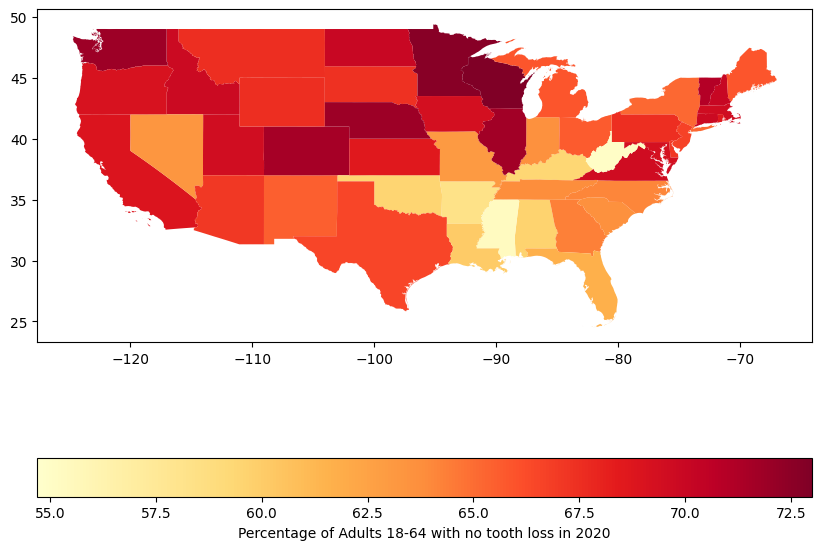

In [ ]:
## MIN AND MAX OF CHLOROPLETH GRAPH
VMIN = cdi_tooth_loss.DataValue.min()
VMAX = cdi_tooth_loss.DataValue.max()

mergedData[mergedData.YearStart == 2020].plot(
    figsize = (10,10),
    column = "DataValue",
    legend = True,
    legend_kwds = {"label": "Percentage of Adults 18-64 with no tooth loss in 2020", "orientation": "horizontal"},
    cmap = MAPCOLOR,
    vmin = VMIN,
    vmax = VMAX,
    );

**Plots of Adults 65+ with all teeth missing**

In [ ]:
# No tooth loss data on elders
cdi_elder_tooth_loss = filterQuestion(cdi_oral, "All teeth lost among adults aged 65 years and older")
mergedElderData = geoData.merge(cdi_elder_tooth_loss,left_on="STUSPS", right_on="LocationAbbr")

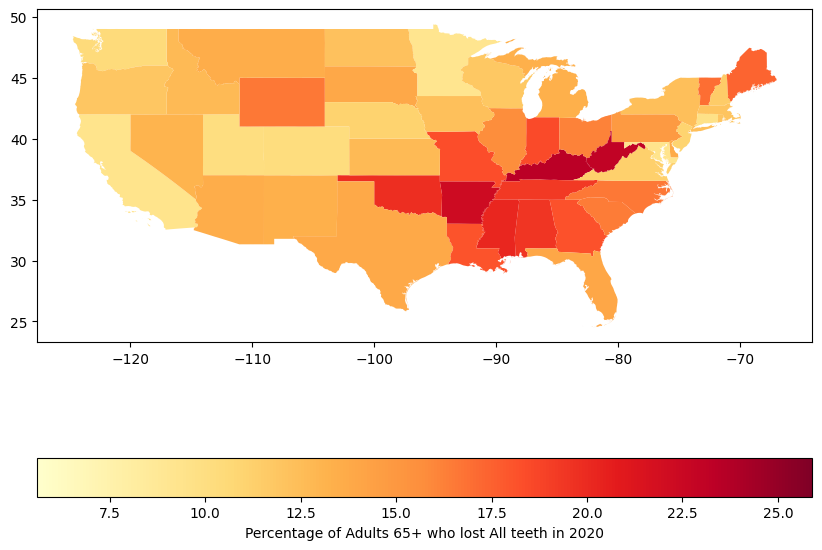

In [ ]:
## MIN AND MAX OF CHLOROPLETH GRAPH
VMIN = cdi_elder_tooth_loss.DataValue.min()
VMAX = cdi_elder_tooth_loss.DataValue.max()

mergedElderData[mergedElderData.YearStart == 2020].plot(
    figsize = (10,10),
    column = 'DataValue',
    legend = True,
    legend_kwds = {"label": "Percentage of Adults 65+ who lost All teeth in 2020", "orientation": "horizontal"},
    cmap = MAPCOLOR,
    vmin = VMIN,
    vmax = VMAX,
    );

_Notice deep south has worst dental health._

**Comparing plots of variables(limited to data found from CDC Chronic Disease Data)**

In [ ]:
## CONCATENATE ALL 2020 DATA INTO ONE DATAFRAME HOLDING ALL FEATURES AND Y's(Tooth loss)
# This is just for EDA, might include other years to methods later 
cdi_dentist_visits = filterQuestion(cdi_oral, "Visited dentist or dental clinic in the past year among adults")
cdi_smoker = filterQuestion(cdi_tobacco, "Current cigarette smoking among adults")
## what does this even mean?? what is considered short sleep
cdi_short_sleep_duration = filterQuestion(cdi_sleep, "Short sleep duration among adults")
cdi_obesity = filterQuestion(cdi_nutrition, "Obesity among adults")

## These two only have years 2019 and 2021...
cdi_low_fruit_consumption = filterQuestion(cdi_nutrition, "Consumed fruit less than one time daily among adults")
cdi_low_veget_consumption = filterQuestion(cdi_nutrition, "Consumed vegetables less than one time daily among adults")

def getDataCol(data):
    return data[data.YearStart == 2020][["DataValue"]].values
    
data_2020 = cdi_tooth_loss[cdi_tooth_loss.YearStart == 2020][["LocationAbbr", "DataValue"]].rename(columns = {"DataValue": "No_Tooth_Loss_18_64_pct"})
data_2020["Complete_Tooth_Loss_65_plus_pct"] = getDataCol(cdi_elder_tooth_loss)
data_2020["Dentist_Visits_for_Adults_pct"] = getDataCol(cdi_dentist_visits)
data_2020["Adults_who_Smoke_pct"] = getDataCol(cdi_smoker)
data_2020["Adults_who_have_Short_Sleep_Duration_pct"] = getDataCol(cdi_short_sleep_duration)
data_2020["Adults_who_have_Obesity_pct"] = getDataCol(cdi_obesity)

In [ ]:
data_2020.head(51)

,LocationAbbr,No_Tooth_Loss_18_64_pct,Complete_Tooth_Loss_65_plus_pct,Dentist_Visits_for_Adults_pct,Adults_who_Smoke_pct,Adults_who_have_Short_Sleep_Duration_pct,Adults_who_have_Obesity_pct
0,AK,67.3,13.1,62.6,18.0,31.6,31.8
1,AL,59.7,19.5,61.3,19.5,39.1,39.3
2,AR,58.3,22.3,57.1,21.6,35.8,37.2
3,AZ,67.1,13.6,60.6,13.7,33.5,31.5
4,CA,68.9,9.4,64.3,9.0,31.3,30.2
5,CO,71.5,10.2,67.0,12.6,27.1,24.2
6,CT,69.8,9.7,72.5,12.6,32.9,29.5
7,DE,67.1,13.7,63.9,15.8,33.9,36.2
8,FL,61.7,14.0,60.7,15.5,34.0,28.3
9,GA,64.3,18.2,60.5,16.3,36.2,34.3


In [ ]:
mergedData2 = geoData.merge(data_2020,left_on="STUSPS",right_on="LocationAbbr")

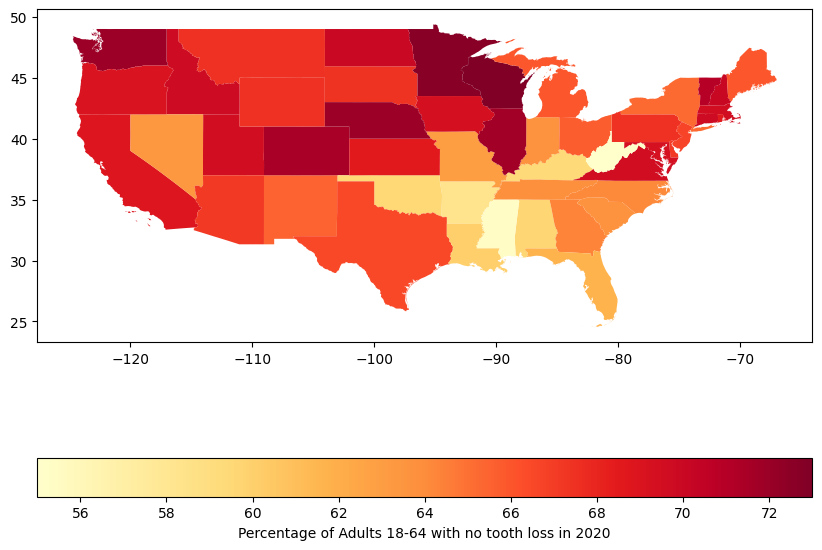

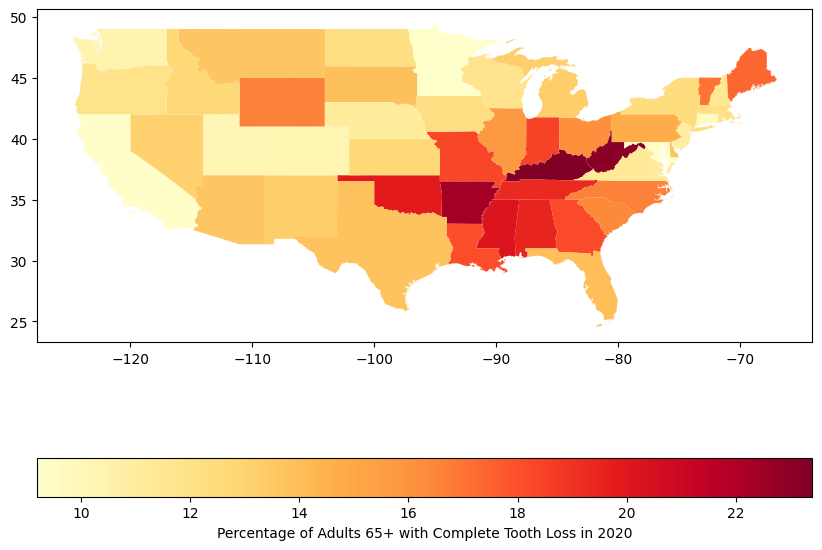

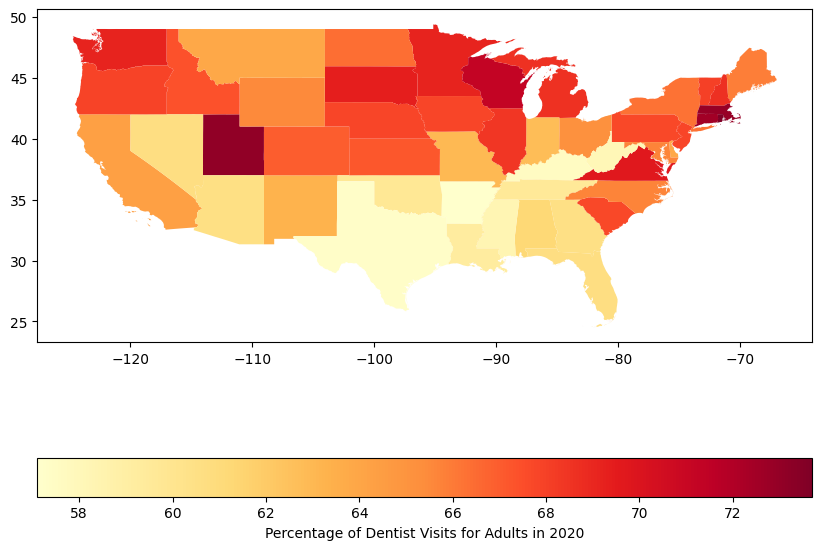

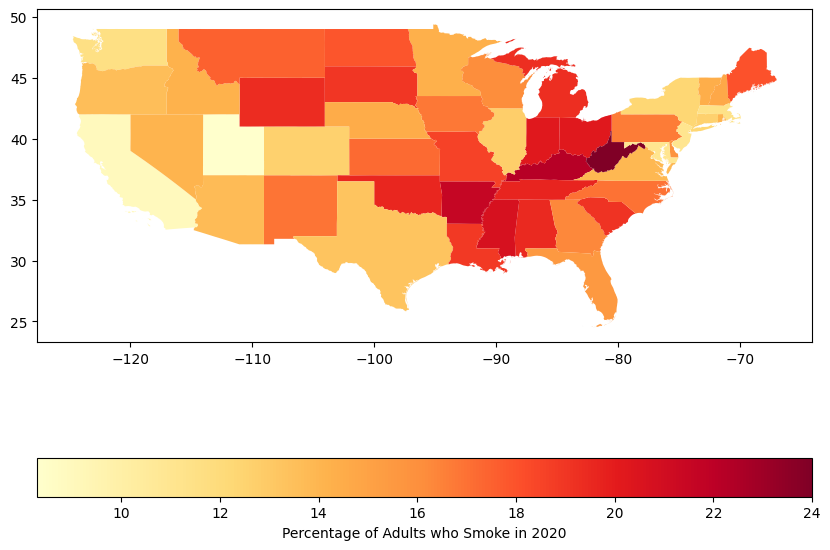

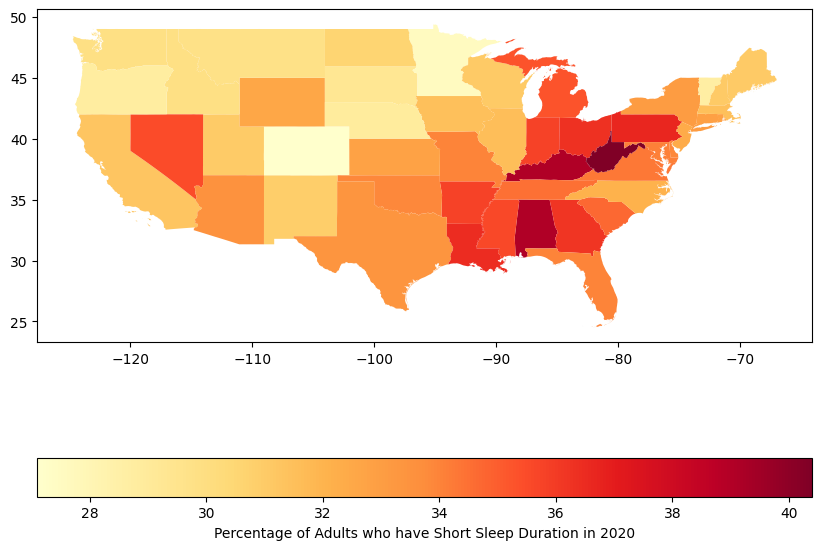

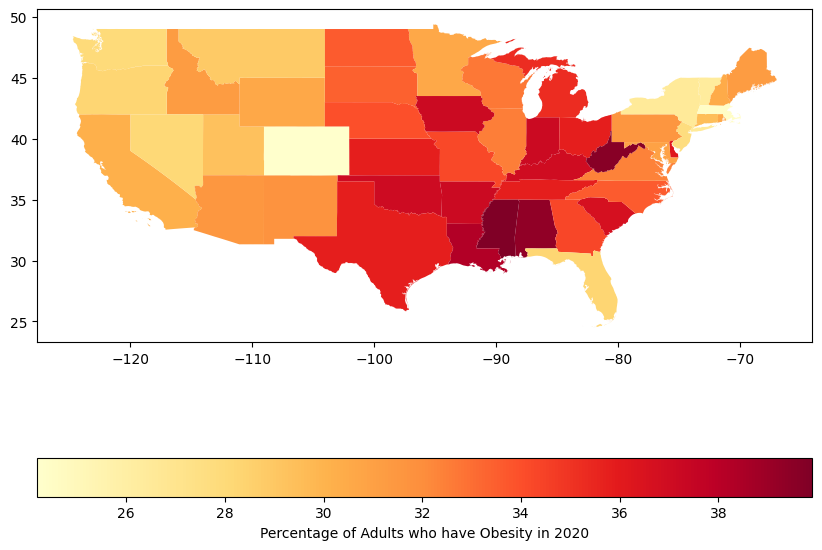

In [ ]:
mergedData2.plot(
    figsize = (10,10),
    column = "No_Tooth_Loss_18_64_pct",
    legend = True,
    legend_kwds = {"label": "Percentage of Adults 18-64 with no tooth loss in 2020", "orientation": "horizontal"},
    cmap = MAPCOLOR,
    vmin = mergedData2.No_Tooth_Loss_18_64_pct.min(),
    vmax = mergedData2.No_Tooth_Loss_18_64_pct.max(),
    );
mergedData2.plot(
    figsize = (10,10),
    column = "Complete_Tooth_Loss_65_plus_pct",
    legend = True,
    legend_kwds = {"label": "Percentage of Adults 65+ with Complete Tooth Loss in 2020", "orientation": "horizontal"},
    cmap = MAPCOLOR,
    vmin = mergedData2.Complete_Tooth_Loss_65_plus_pct.min(),
    vmax = mergedData2.Complete_Tooth_Loss_65_plus_pct.max(),
    );
mergedData2.plot(
    figsize = (10,10),
    column = "Dentist_Visits_for_Adults_pct",
    legend = True,
    legend_kwds = {"label": "Percentage of Dentist Visits for Adults in 2020", "orientation": "horizontal"},
    cmap = MAPCOLOR,
    vmin = mergedData2.Dentist_Visits_for_Adults_pct.min(),
    vmax = mergedData2.Dentist_Visits_for_Adults_pct.max(),
    );
mergedData2.plot(
    figsize = (10,10),
    column = "Adults_who_Smoke_pct",
    legend = True,
    legend_kwds = {"label": "Percentage of Adults who Smoke in 2020", "orientation": "horizontal"},
    cmap = MAPCOLOR,
    vmin = mergedData2.Adults_who_Smoke_pct.min(),
    vmax = mergedData2.Adults_who_Smoke_pct.max(),
    );
mergedData2.plot(
    figsize = (10,10),
    column = "Adults_who_have_Short_Sleep_Duration_pct",
    legend = True,
    legend_kwds = {"label": "Percentage of Adults who have Short Sleep Duration in 2020", "orientation": "horizontal"},
    cmap = MAPCOLOR,
    vmin = mergedData2.Adults_who_have_Short_Sleep_Duration_pct.min(),
    vmax = mergedData2.Adults_who_have_Short_Sleep_Duration_pct.max(),
    );
mergedData2.plot(
    figsize = (10,10),
    column = "Adults_who_have_Obesity_pct",
    legend = True,
    legend_kwds = {"label": "Percentage of Adults who have Obesity in 2020", "orientation": "horizontal"},
    cmap = MAPCOLOR,
    vmin = mergedData2.Adults_who_have_Obesity_pct.min(),
    vmax = mergedData2.Adults_who_have_Obesity_pct.max(),
    );

Here, Adults 18-64 tooth health and Adults 65+ total tooth loss, which I will call 'dental health', are values I want to predict using Dentist visits, tobacco usage, sleep health and obesity data, all state level. The graphs above show states with low dentist visits percentage are usually the states that have low 'dental health'. Likewise, states with high tobacco use, low quality sleep, and high obesity are some of the same states with low 'dental health'.

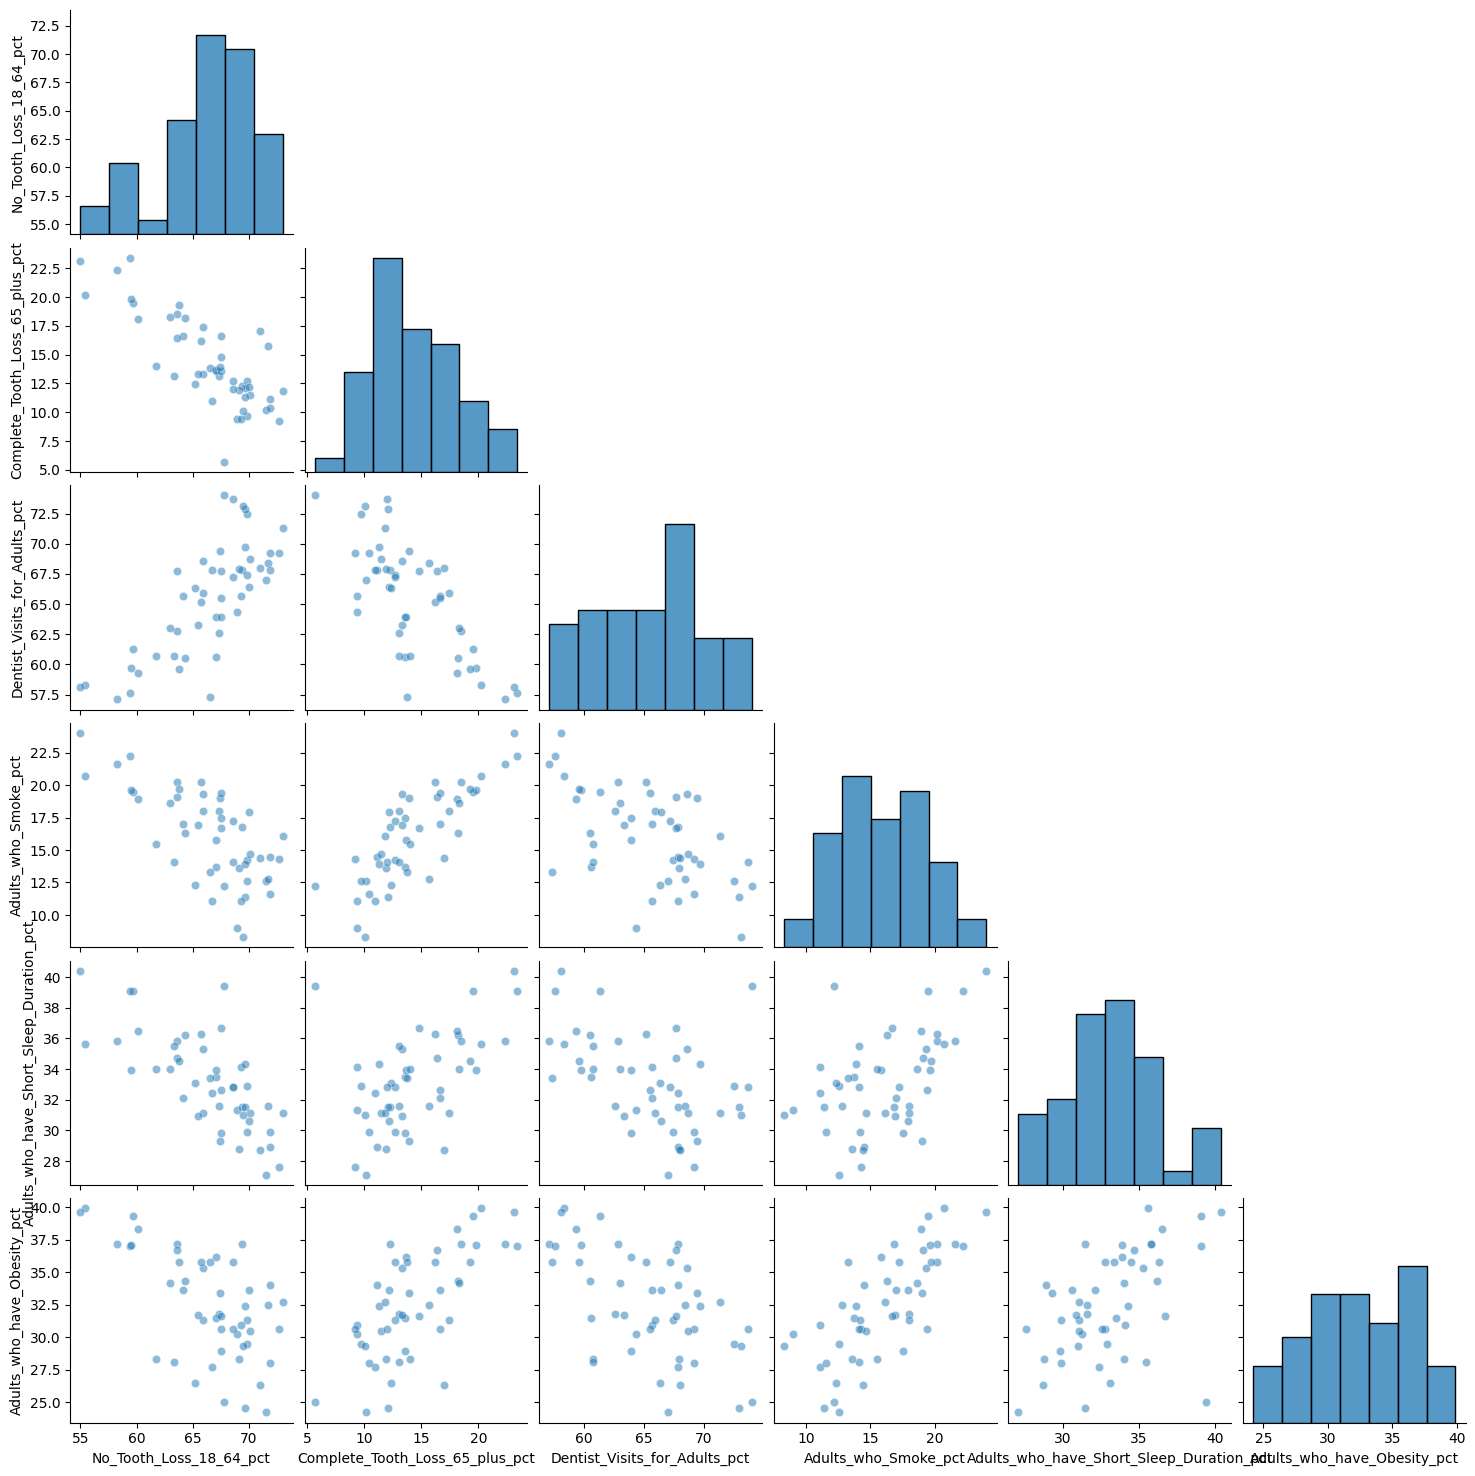

In [ ]:
## Taken from Lab 9
fig = sns.pairplot(data_2020,  plot_kws=dict(marker="o", alpha = 0.5))
for i, j in zip(*np.triu_indices_from(fig.axes, 1)):
    fig.axes[i, j].set_visible(False)
plt.show()

# GLM

In [ ]:
## All these funcs assume you have a valid topic and question. Work ONLY on CDC data
def filterTopic(data, topic):
    #Hyunji's data cleaning
    this_data = data[data.Topic.str.contains(topic, na=False)]
    # Remove rows with missing or non-numeric 'DataValue'
    this_data = this_data[pd.to_numeric(this_data.DataValue, errors='coerce').notna()]
    # Convert 'DataValue' to float
    this_data.DataValue = this_data.DataValue.astype(float)
    this_data.reset_index(drop=True, inplace=True)
    # selects only important columns, feel free to add new columns
    return this_data[["YearStart", "LocationAbbr", "Question", "DataValue"]]

def filterQuestion(filteredOnTopic, question, col_rename="DataValue"):
    filteredOnQuestion = filteredOnTopic[filteredOnTopic.Question == question]
    # Removes any territories
    badAbbr = ["GU", "DC", "US", "PR", "VI"]
    filteredOnQuestion = filteredOnQuestion.drop(filteredOnQuestion[filteredOnQuestion.LocationAbbr.isin(badAbbr)].index)
    filteredOnQuestion  = filteredOnQuestion.sort_values(by = ["YearStart", "LocationAbbr"])
    filteredOnQuestion.reset_index(drop=True, inplace=True)
    return filteredOnQuestion[["YearStart", "LocationAbbr", "DataValue"]].rename(columns = {"DataValue": col_rename, "YearStart" : "Year"})

def filterTopicAndQuestion(data, topic, question):
    filteredOnTopic = filterTopic(data, topic)
    return filterQuestion(filteredOnTopic, question)

def selectCols(features, data):
    data = data[features].dropna()
    return data

def runModel(x_train, x_test, y_train, y_test):
    x_train = sm.add_constant(x_train)
    
    poisson_model = sm.GLM(y_train, x_train, family=sm.families.Poisson())
    poisson_results = poisson_model.fit()
    print(poisson_results.summary())
    print("Model with Poisson AIC :" + str(poisson_results.aic))
    
    negbin_model = sm.GLM(y_train, x_train, family=sm.families.NegativeBinomial())
    negbin_results = negbin_model.fit()
    print(negbin_results.summary())
    print("Model with NegBin AIC :" + str(negbin_results.aic))
    
    gamma_model = sm.GLM(y_train, x_train, family=sm.families.Gamma())
    gamma_results = gamma_model.fit()
    print(gamma_results.summary())
    print("Model with Gamma AIC :" + str(gamma_results.aic))

    predict1 = poisson_results.predict(sm.add_constant(x_test))
    differences1 = predict1.values - y_test.values

    predict2 = negbin_results.predict(sm.add_constant(x_test))
    differences2 = predict2.values - y_test.values

    predict3 = gamma_results.predict(sm.add_constant(x_test))
    differences3 = predict3.values - y_test.values
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
    
    ax1.hist(differences1, histtype= "bar", density = True)
    ax1.set_title("Poisson")
    ax1.axvline(differences1.mean(), color='k', linestyle='dashed', linewidth=1, label = "Poisson mean = " + str(differences1.mean()))
    ax1.axvline(differences1.var(), color='k', linestyle=':', linewidth=1, label = "Poisson var = " + str(differences1.var()))
    ax1.axvline(-differences1.var(), color='k', linestyle=':', linewidth=1)
    ax1.legend()
    
    ax2.hist(differences2, histtype= "bar", density = True)
    ax2.set_title("NegBin")
    ax2.axvline(differences2.mean(), color='k', linestyle='dashed', linewidth=1, label = "NegBin mean = " + str(differences2.mean()))
    ax2.axvline(differences2.var(), color='k', linestyle=':', linewidth=1, label = "NegBin var = " + str(differences2.var()))
    ax2.axvline(-differences2.var(), color='k', linestyle=':', linewidth=1)
    ax2.legend()

    ax3.hist(differences3, histtype= "bar", density = True)
    ax3.set_title("Gamma")
    ax3.axvline(differences3.mean(), color='k', linestyle='dashed', linewidth=1, label = "Gamma mean = " + str(differences3.mean()))
    ax3.axvline(differences3.var(), color='k', linestyle=':', linewidth=1, label = "Gamma var = " + str(differences3.var()))
    ax3.axvline(-differences3.var(), color='k', linestyle=':', linewidth=1)
    ax3.legend()

In [ ]:
## Load Useful Data
data = pd.read_csv("GLM_Non_Parametric/U.S.Chronic_Disease_Filtered.csv")

cdi_oral = filterTopic(data, "Oral")
cdi_tobacco = filterTopic(data, "Tobacco")
cdi_sleep = filterTopic(data, "Overarching Conditions")
cdi_nutrition = filterTopic(data, "Nutrition, Physical Activity, and Weight Status")

water_data = pd.read_csv("GLM_Non_Parametric/Water_Fluoridation.csv")
water_data = water_data[["Year", "LocationAbbr", "DataValue"]].rename(columns = {"DataValue" : "Fluoridated_Water_pct"})

stateAbbr = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
stateNames = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]
df_states = pd.DataFrame(data = {'LocationAbbr': stateAbbr, 'GeoName': stateNames})

income_data = pd.read_csv("GLM_Non_Parametric/Personal_Income.csv", skiprows = [0, 1, 2])
income_data = income_data.drop(["GeoFips", "1998", "1999", "2000", "2001","2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009", "2010" , "2023"], axis = 1)
income_data = income_data.drop([0, 9, 52, 53, 54, 55])
income_data = df_states.merge(income_data, left_on = "GeoName", right_on = "GeoName", how = "left")
income_data.drop(columns = ["GeoName"], inplace = True)

In [ ]:
# No tooth loss data
cdi_tooth_loss = filterQuestion(cdi_oral, "No tooth loss among adults aged 18-64 years", "No_Tooth_Loss_18_64_pct")

# No tooth loss data on elders
cdi_elder_tooth_loss = filterQuestion(cdi_oral, "All teeth lost among adults aged >= 65 years", "Complete_Tooth_Loss_65_plus_pct")

# Dentist visits data
cdi_dentist_visits = filterQuestion(cdi_oral, "Visits to dentist or dental clinic among adults aged >= 18 years", "Dentist_Visits_pct")

# Smoking adults data
cdi_smoker = filterQuestion(cdi_tobacco, "Current smoking among adults aged >= 18 years", "Smoke_pct")

# Sleep Duratuon adults data
cdi_short_sleep_duration = filterQuestion(cdi_sleep, "Prevalence of sufficient sleep among adults aged >= 18 years", "Sleep_Duration_pct")

# Obesity adult data
cdi_obesity = filterQuestion(cdi_nutrition, "Obesity among adults aged >= 18 years", "Obesity_pct")

#### DATA HAS NaN values! This is so we can select columns we need and then remove any rows with NaN values, resulting in getting all possible full rows for selection of columns.
data_wrangled = cdi_tooth_loss.merge(cdi_elder_tooth_loss, left_on = ["Year", "LocationAbbr"], right_on = ["Year", "LocationAbbr"], how = "outer")
data_wrangled = data_wrangled.merge(cdi_dentist_visits, left_on = ["Year", "LocationAbbr"], right_on = ["Year", "LocationAbbr"], how = "outer")
data_wrangled = data_wrangled.merge(cdi_smoker, left_on = ["Year", "LocationAbbr"], right_on = ["Year", "LocationAbbr"], how = "outer")
data_wrangled = data_wrangled.merge(cdi_short_sleep_duration, left_on = ["Year", "LocationAbbr"], right_on = ["Year", "LocationAbbr"], how = "outer")
data_wrangled = data_wrangled.merge(cdi_obesity, left_on = ["Year", "LocationAbbr"], right_on = ["Year", "LocationAbbr"], how = "outer")
data_wrangled = data_wrangled.merge(water_data, left_on = ["Year", "LocationAbbr"], right_on = ["Year", "LocationAbbr"], how = "outer")
data_wrangled = data_wrangled.sort_values(by = ["Year", "LocationAbbr"])
data_wrangled.dropna(subset=["No_Tooth_Loss_18_64_pct", "Complete_Tooth_Loss_65_plus_pct"], how = "all", inplace=True)
data_wrangled.reset_index(drop=True, inplace=True)

income_lis = []
for col in data_wrangled.Year.unique():
    income_lis = np.append(income_lis, income_data[str(col)].values)
data_wrangled["Avg_Personal_Income"] = income_lis
data_wrangled.head()

,Year,LocationAbbr,No_Tooth_Loss_18_64_pct,Complete_Tooth_Loss_65_plus_pct,Dentist_Visits_pct,Smoke_pct,Sleep_Duration_pct,Obesity_pct,Fluoridated_Water_pct,Avg_Personal_Income
0,2012,AK,64.3,16.1,67.3,20.0,62.1,25.7,52.9,41617.0
1,2012,AL,52.2,23.8,58.4,24.4,NaN,32.8,78.4,55069.0
2,2012,AR,54.8,24.0,54.7,25.7,NaN,35.1,66.9,39253.0
3,2012,AZ,61.0,13.8,61.1,17.2,NaN,26.3,57.8,43016.0
4,2012,CA,64.3,8.8,66.8,12.5,NaN,25.0,63.7,46170.0


Simple Models

                    Generalized Linear Model Regression Results                    
Dep. Variable:     No_Tooth_Loss_18_64_pct   No. Observations:                  200
Model:                                 GLM   Df Residuals:                      197
Model Family:                      Poisson   Df Model:                            2
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -612.26
Date:                     Mon, 06 May 2024   Deviance:                       24.876
Time:                             13:01:58   Pearson chi2:                     24.6
No. Iterations:                          3   Pseudo R-squ. (CS):             0.2154
Covariance Type:                 nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

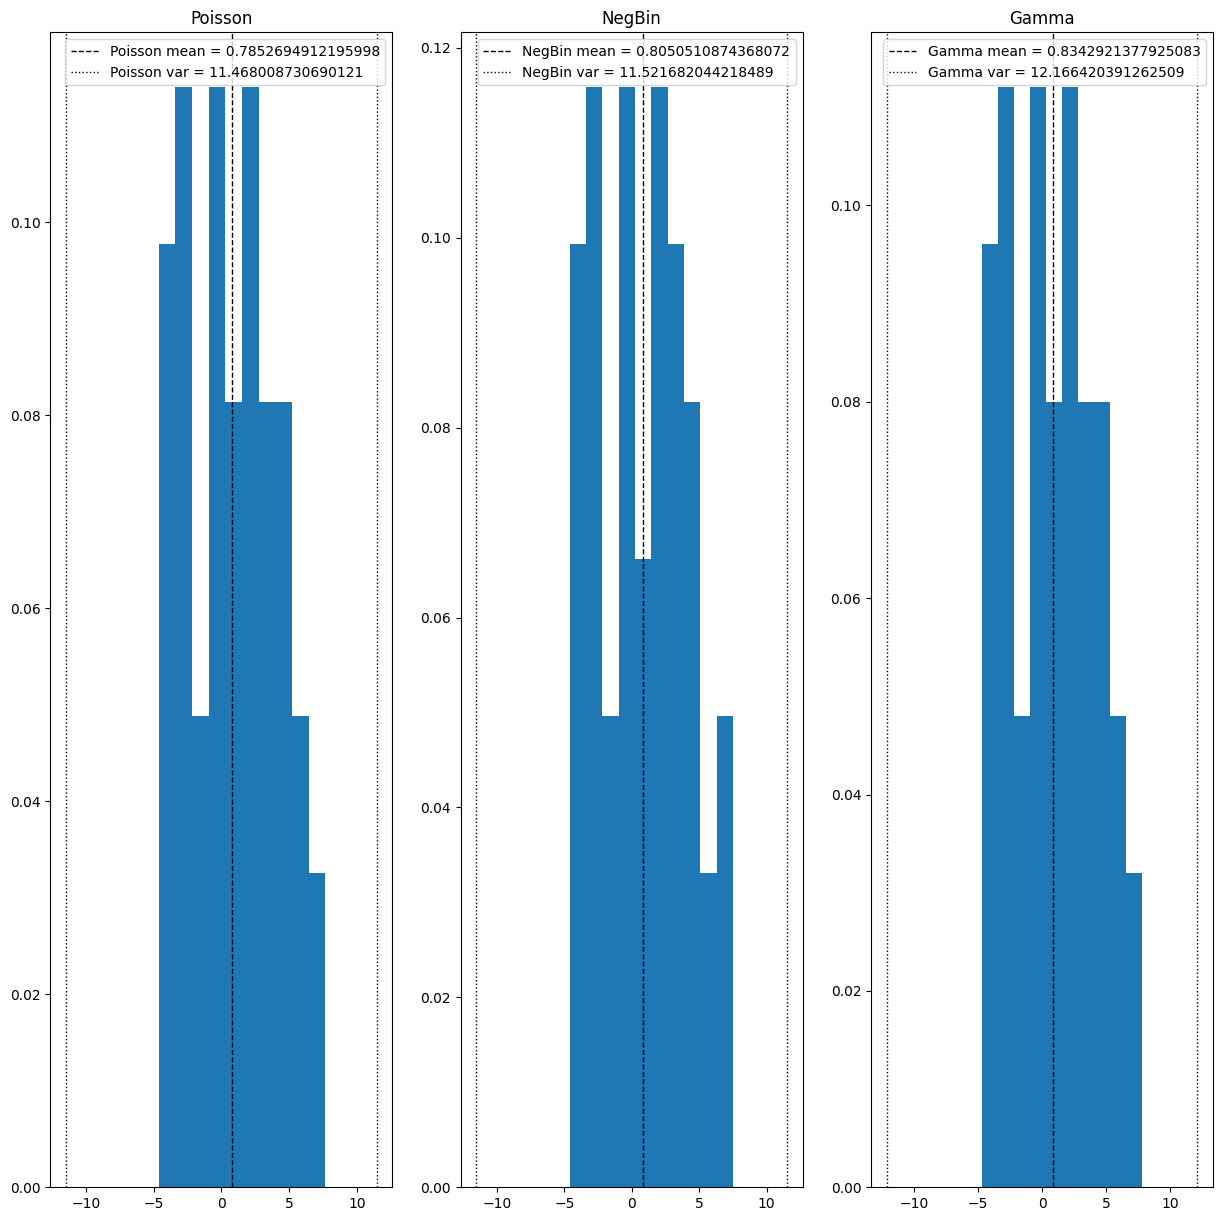

In [ ]:
simple_data_1 = selectCols(["Year", "LocationAbbr", "No_Tooth_Loss_18_64_pct", "Dentist_Visits_pct", "Smoke_pct"], data_wrangled)
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(simple_data_1[["Dentist_Visits_pct", "Smoke_pct"]], simple_data_1["No_Tooth_Loss_18_64_pct"], train_size=0.8)
runModel(x_train_1, x_test_1, y_train_1, y_test_1 )

                    Generalized Linear Model Regression Results                    
Dep. Variable:     No_Tooth_Loss_18_64_pct   No. Observations:                  123
Model:                                 GLM   Df Residuals:                      119
Model Family:                      Poisson   Df Model:                            3
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -380.96
Date:                     Mon, 06 May 2024   Deviance:                       24.680
Time:                             13:01:59   Pearson chi2:                     24.4
No. Iterations:                          3   Pseudo R-squ. (CS):             0.1582
Covariance Type:                 nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

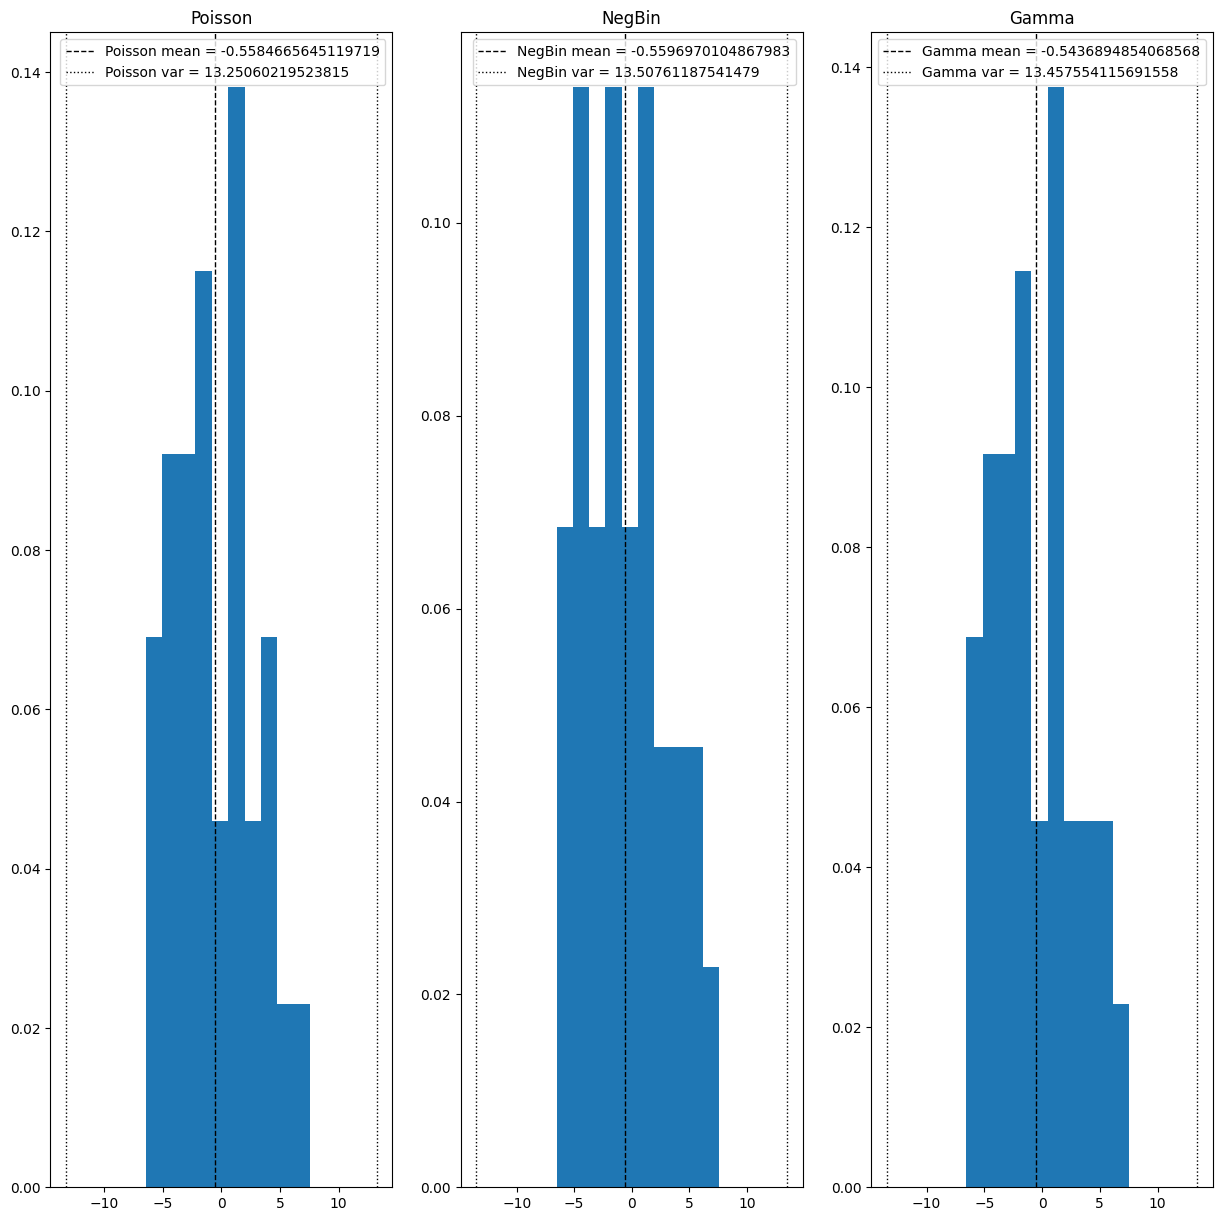

In [ ]:
simple_data_2 = selectCols(["Year", "LocationAbbr", "No_Tooth_Loss_18_64_pct", "Obesity_pct", "Sleep_Duration_pct", "Fluoridated_Water_pct"], data_wrangled)
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(simple_data_2[[ "Obesity_pct", "Sleep_Duration_pct", "Fluoridated_Water_pct"]], simple_data_2["No_Tooth_Loss_18_64_pct"], train_size=0.8)
runModel(x_train_1, x_test_1, y_train_1, y_test_1 )

                    Generalized Linear Model Regression Results                    
Dep. Variable:     No_Tooth_Loss_18_64_pct   No. Observations:                  200
Model:                                 GLM   Df Residuals:                      197
Model Family:                      Poisson   Df Model:                            2
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -618.14
Date:                     Mon, 06 May 2024   Deviance:                       36.883
Time:                             13:02:00   Pearson chi2:                     36.5
No. Iterations:                          3   Pseudo R-squ. (CS):             0.1960
Covariance Type:                 nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

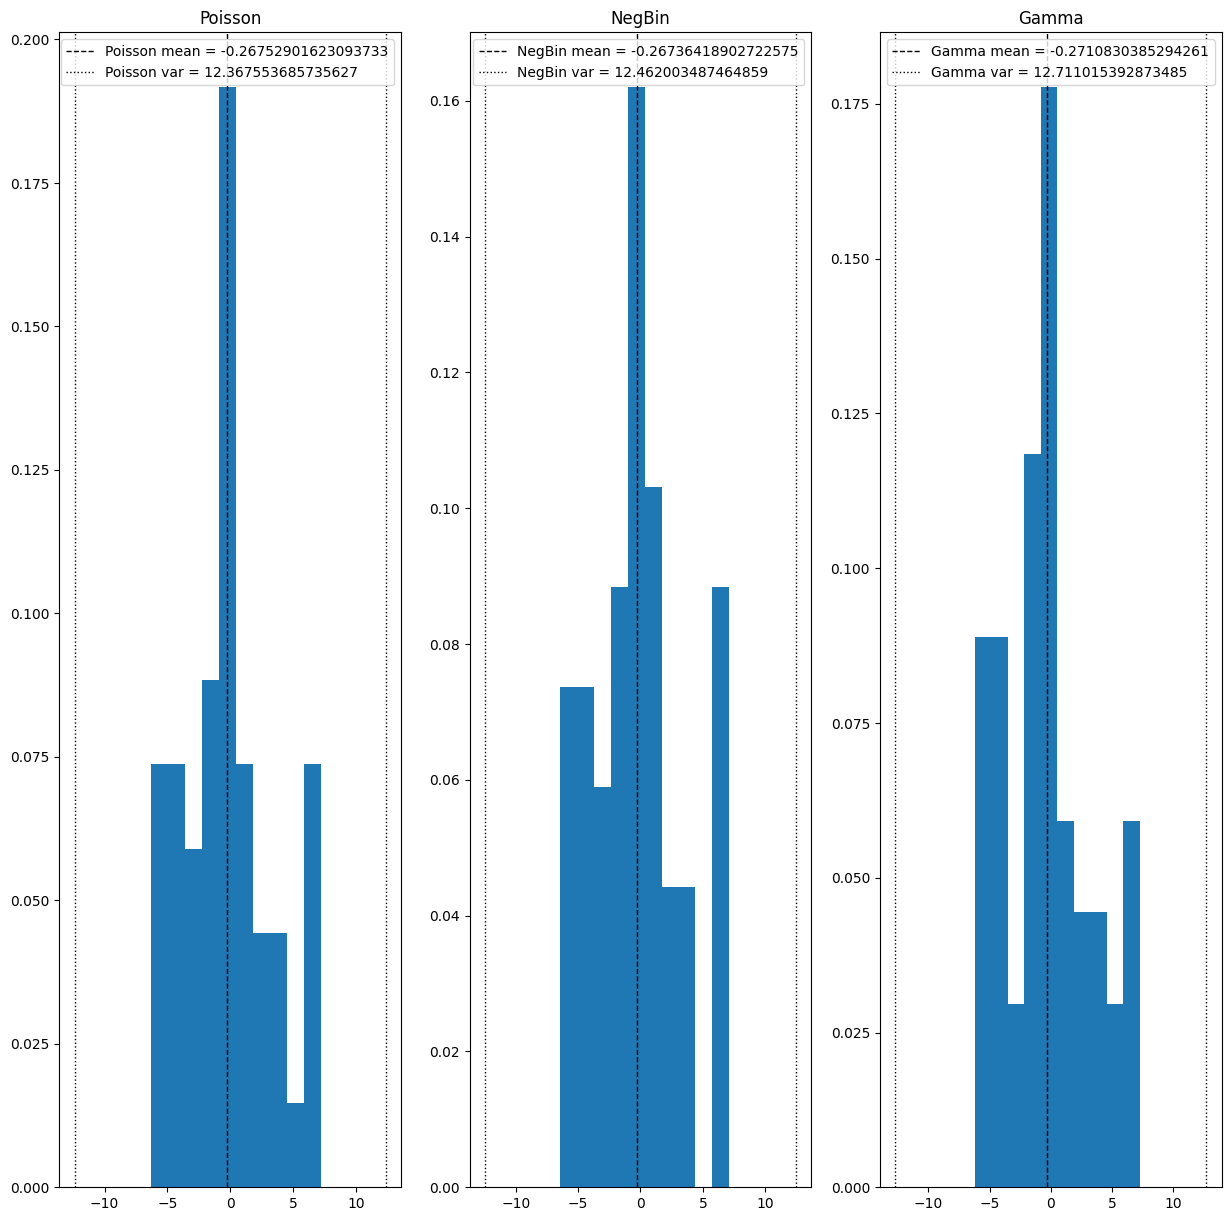

In [ ]:
simple_data_3 = selectCols(["Year", "LocationAbbr", "No_Tooth_Loss_18_64_pct", "Dentist_Visits_pct", "Avg_Personal_Income"], data_wrangled)
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(simple_data_3[[ "Dentist_Visits_pct", "Avg_Personal_Income"]], simple_data_3["No_Tooth_Loss_18_64_pct"], train_size=0.8)
runModel(x_train_1, x_test_1, y_train_1, y_test_1 )

                    Generalized Linear Model Regression Results                    
Dep. Variable:     No_Tooth_Loss_18_64_pct   No. Observations:                  163
Model:                                 GLM   Df Residuals:                      159
Model Family:                      Poisson   Df Model:                            3
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -497.85
Date:                     Mon, 06 May 2024   Deviance:                       16.687
Time:                             13:02:00   Pearson chi2:                     16.5
No. Iterations:                          3   Pseudo R-squ. (CS):             0.2059
Covariance Type:                 nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

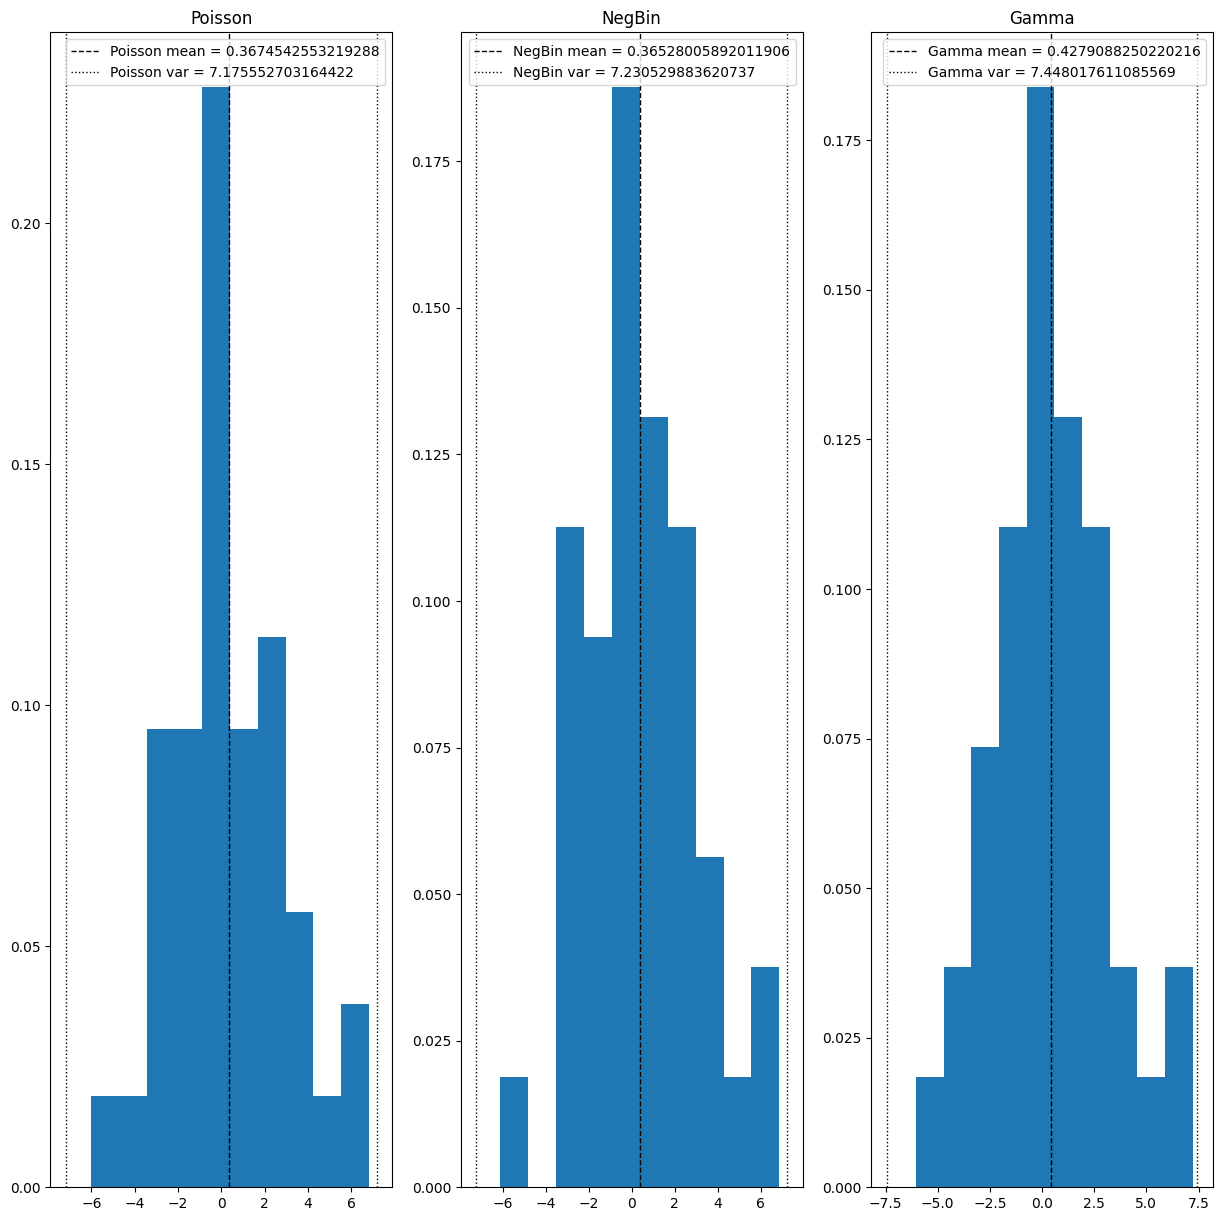

In [ ]:
simple_data_4 = selectCols(["Year", "LocationAbbr", "No_Tooth_Loss_18_64_pct", "Obesity_pct", "Sleep_Duration_pct", "Dentist_Visits_pct"], data_wrangled)
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(simple_data_4[[ "Obesity_pct", "Sleep_Duration_pct", "Dentist_Visits_pct"]], simple_data_4["No_Tooth_Loss_18_64_pct"], train_size=0.8)
runModel(x_train_1, x_test_1, y_train_1, y_test_1 )

                    Generalized Linear Model Regression Results                    
Dep. Variable:     No_Tooth_Loss_18_64_pct   No. Observations:                  163
Model:                                 GLM   Df Residuals:                      158
Model Family:                      Poisson   Df Model:                            4
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -496.09
Date:                     Mon, 06 May 2024   Deviance:                       13.585
Time:                             13:02:01   Pearson chi2:                     13.4
No. Iterations:                          3   Pseudo R-squ. (CS):             0.2434
Covariance Type:                 nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

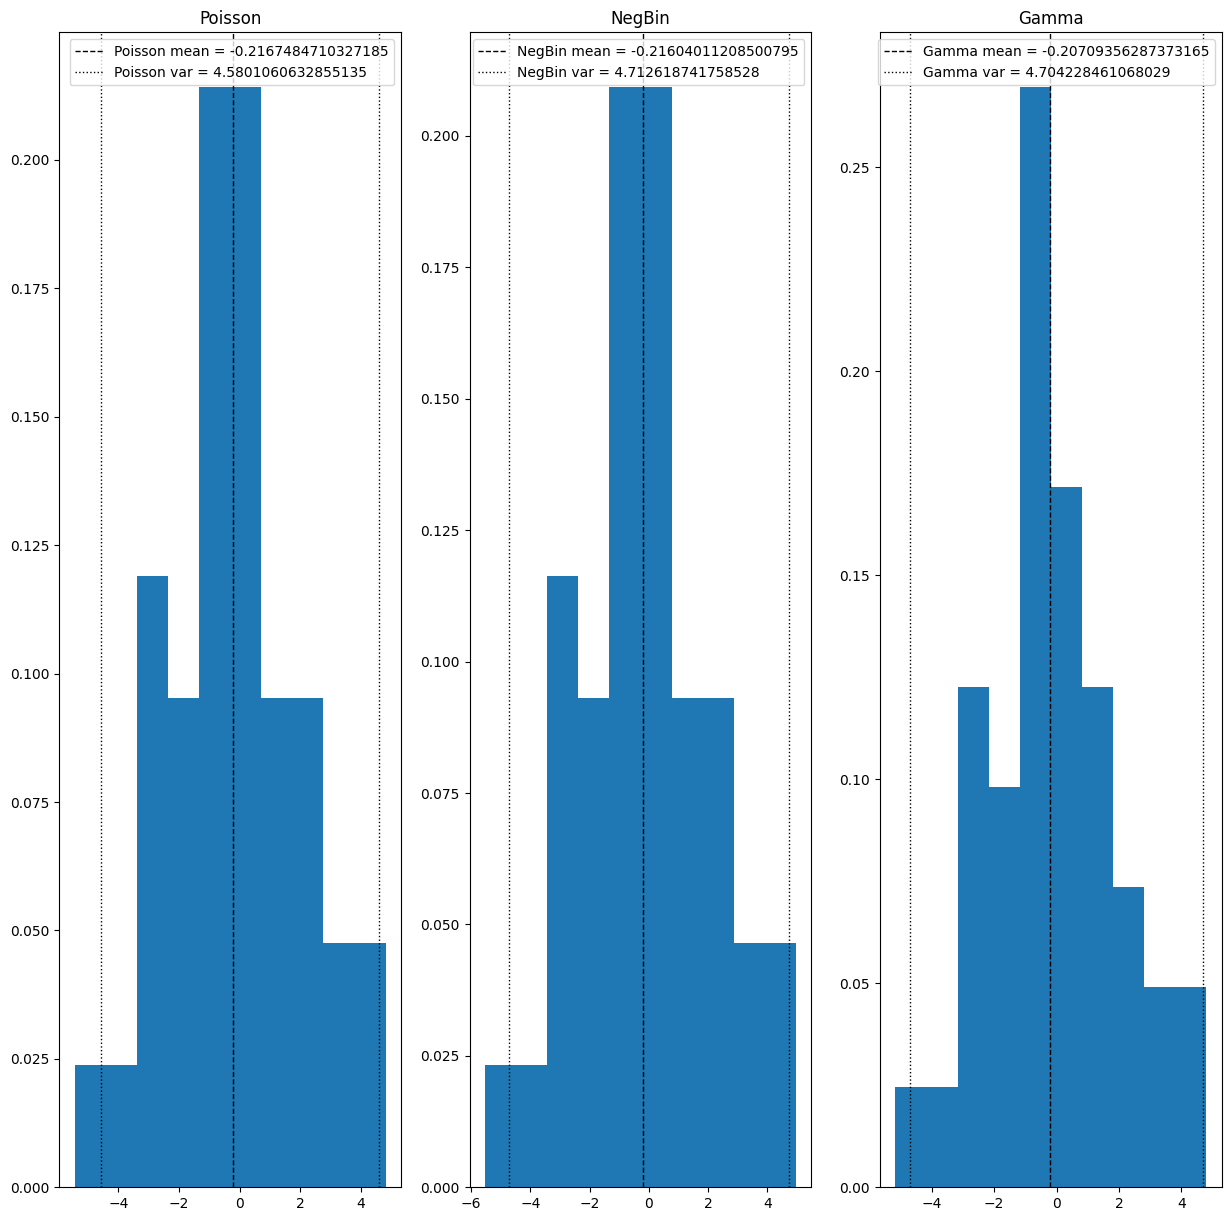

In [ ]:
complex_data_1 = selectCols(["Year", "LocationAbbr", "No_Tooth_Loss_18_64_pct", "Dentist_Visits_pct", "Smoke_pct", "Obesity_pct", "Sleep_Duration_pct"], data_wrangled)
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(complex_data_1[[ "Dentist_Visits_pct", "Smoke_pct", "Obesity_pct", "Sleep_Duration_pct"]], complex_data_1["No_Tooth_Loss_18_64_pct"], train_size=0.8)
runModel(x_train_1, x_test_1, y_train_1, y_test_1 )

                    Generalized Linear Model Regression Results                    
Dep. Variable:     No_Tooth_Loss_18_64_pct   No. Observations:                  123
Model:                                 GLM   Df Residuals:                      116
Model Family:                      Poisson   Df Model:                            6
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -374.40
Date:                     Mon, 06 May 2024   Deviance:                       11.573
Time:                             13:02:02   Pearson chi2:                     11.4
No. Iterations:                          3   Pseudo R-squ. (CS):             0.2391
Covariance Type:                 nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

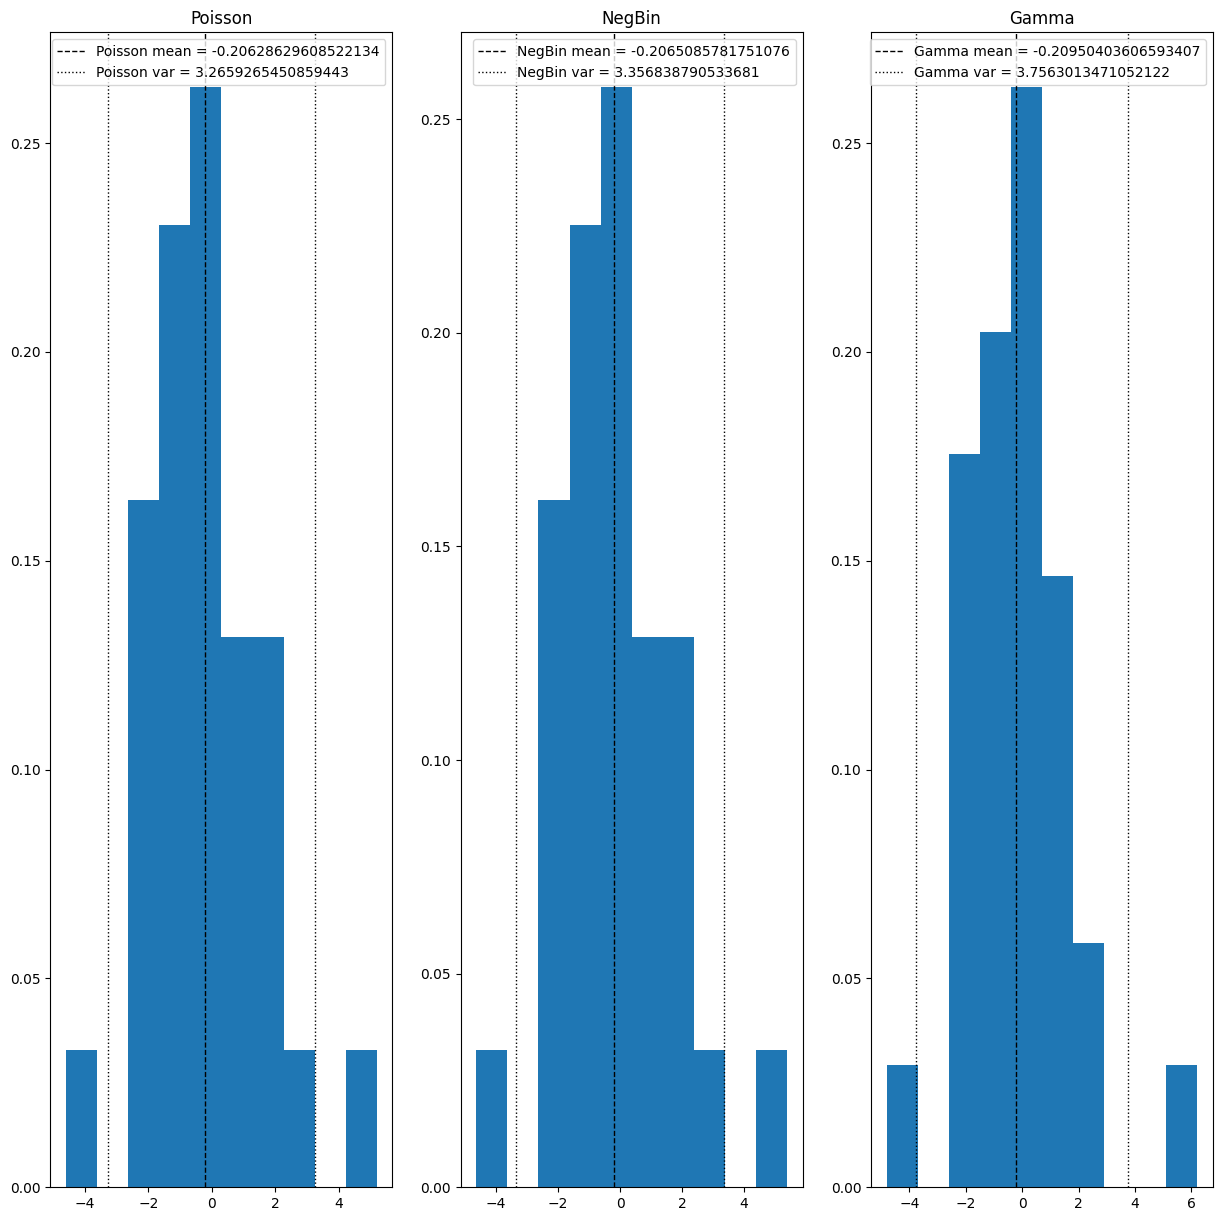

In [ ]:
complex_data_2 = selectCols(["Year", "LocationAbbr", "No_Tooth_Loss_18_64_pct", "Dentist_Visits_pct", "Smoke_pct", "Obesity_pct", "Sleep_Duration_pct", "Fluoridated_Water_pct", "Avg_Personal_Income"], data_wrangled)
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(complex_data_2[[ "Dentist_Visits_pct", "Smoke_pct", "Obesity_pct", "Sleep_Duration_pct", "Fluoridated_Water_pct", "Avg_Personal_Income"]], complex_data_2["No_Tooth_Loss_18_64_pct"], train_size=0.8)
runModel(x_train_1, x_test_1, y_train_1, y_test_1 )

# Ordinary Least Squares regression (OLS)

In [ ]:
import statsmodels.api as sm
def ordinary_least_squares_regression(dataframe, target_variable, explanatory_variables, intercept = False):
    inputs = dataframe[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    return(sm.OLS(dataframe[target_variable], inputs).fit())

The analyses of the variables are as follows.

**Single Parameter (With "No_Tooth_Loss_18_64_pct"):**

**1)** "No_Tooth_Loss_18_64_pct" vs. "Complete_Tooth_Loss_65_plus_pct"

**2)** "No_Tooth_Loss_18_64_pct" vs. "Dentist_Visits_for_Adults_pct"

**3)** "No_Tooth_Loss_18_64_pct" vs. "Adults_who_Smoke_pct"

**4)** "No_Tooth_Loss_18_64_pct" vs. "Adults_who_have_Short_Sleep_Duration_pct"

**5)** "No_Tooth_Loss_18_64_pct" vs. "Adults_who_have_Obesity_pct"

**Two Paramaters (With "No_Tooth_Loss_18_64_pct"):**

**_With "Complete_Tooth_Loss_65_plus_pct":_**

**1)** "No_Tooth_Loss_18_64_pct" vs. ["Complete_Tooth_Loss_65_plus_pct", "Dentist_Visits_for_Adults_pct"]

**2)** "No_Tooth_Loss_18_64_pct" vs. ["Complete_Tooth_Loss_65_plus_pct", "Adults_who_Smoke_pct"]

**3)** "No_Tooth_Loss_18_64_pct" vs. ["Complete_Tooth_Loss_65_plus_pct", "Adults_who_have_Short_Sleep_Duration_pct"]

**4)** "No_Tooth_Loss_18_64_pct" vs. ["Complete_Tooth_Loss_65_plus_pct", "Adults_who_have_Obesity_pct"]

**_With "Dentist_Visits_for_Adults_pct":_**

**1)** "No_Tooth_Loss_18_64_pct" vs. ["Dentist_Visits_for_Adults_pct", "Adults_who_Smoke_pct"]

**2)** "No_Tooth_Loss_18_64_pct" vs. ["Dentist_Visits_for_Adults_pct", "Adults_who_have_Short_Sleep_Duration_pct"]

**3)** "No_Tooth_Loss_18_64_pct" vs. ["Dentist_Visits_for_Adults_pct", "Adults_who_have_Obesity_pct"]

**_With "Adults_who_Smoke_pct":_**

**1)** "No_Tooth_Loss_18_64_pct" vs. ["Adults_who_Smoke_pct", "Adults_who_have_Short_Sleep_Duration_pct"]

**2)** "No_Tooth_Loss_18_64_pct" vs. ["Adults_who_Smoke_pct", "Adults_who_have_Obesity_pct"]

**_With "Adults_who_have_Short_Sleep_Duration_pct":_**

**1)** "No_Tooth_Loss_18_64_pct" vs. ["Adults_who_have_Short_Sleep_Duration_pct", "Adults_who_have_Obesity_pct"]

## Single Parameter (With "No_Tooth_Loss_18_64_pct")

**1)** "No_Tooth_Loss_18_64_pct" vs. "Complete_Tooth_Loss_65_plus_pct"

In [ ]:
print(ordinary_least_squares_regression(data_2020, "No_Tooth_Loss_18_64_pct", "Complete_Tooth_Loss_65_plus_pct").summary())

                                   OLS Regression Results                                   
Dep. Variable:     No_Tooth_Loss_18_64_pct   R-squared (uncentered):                   0.903
Model:                                 OLS   Adj. R-squared (uncentered):              0.901
Method:                      Least Squares   F-statistic:                              454.8
Date:                     Mon, 06 May 2024   Prob (F-statistic):                    1.91e-26
Time:                             13:02:03   Log-Likelihood:                         -222.60
No. Observations:                       50   AIC:                                      447.2
Df Residuals:                           49   BIC:                                      449.1
Df Model:                                1                                                  
Covariance Type:                 nonrobust                                                  
                                      coef    std err          t      

**2)** "No_Tooth_Loss_18_64_pct" vs. "Dentist_Visits_for_Adults_pct"

In [ ]:
print(ordinary_least_squares_regression(data_2020, "No_Tooth_Loss_18_64_pct", "Dentist_Visits_for_Adults_pct").summary())

                                   OLS Regression Results                                   
Dep. Variable:     No_Tooth_Loss_18_64_pct   R-squared (uncentered):                   0.998
Model:                                 OLS   Adj. R-squared (uncentered):              0.998
Method:                      Least Squares   F-statistic:                          2.272e+04
Date:                     Mon, 06 May 2024   Prob (F-statistic):                    5.12e-67
Time:                             13:02:03   Log-Likelihood:                         -127.32
No. Observations:                       50   AIC:                                      256.6
Df Residuals:                           49   BIC:                                      258.6
Df Model:                                1                                                  
Covariance Type:                 nonrobust                                                  
                                    coef    std err          t      P>

**3)** "No_Tooth_Loss_18_64_pct" vs. "Adults_who_Smoke_pct"

In [ ]:
print(ordinary_least_squares_regression(data_2020, "No_Tooth_Loss_18_64_pct", "Adults_who_Smoke_pct").summary())

                                   OLS Regression Results                                   
Dep. Variable:     No_Tooth_Loss_18_64_pct   R-squared (uncentered):                   0.933
Model:                                 OLS   Adj. R-squared (uncentered):              0.931
Method:                      Least Squares   F-statistic:                              679.2
Date:                     Mon, 06 May 2024   Prob (F-statistic):                    2.26e-30
Time:                             13:02:03   Log-Likelihood:                         -213.39
No. Observations:                       50   AIC:                                      428.8
Df Residuals:                           49   BIC:                                      430.7
Df Model:                                1                                                  
Covariance Type:                 nonrobust                                                  
                           coef    std err          t      P>|t|      

**4)** "No_Tooth_Loss_18_64_pct" vs. "Adults_who_have_Short_Sleep_Duration_pct"

In [ ]:
print(ordinary_least_squares_regression(data_2020, "No_Tooth_Loss_18_64_pct", "Adults_who_have_Short_Sleep_Duration_pct").summary())

                                   OLS Regression Results                                   
Dep. Variable:     No_Tooth_Loss_18_64_pct   R-squared (uncentered):                   0.979
Model:                                 OLS   Adj. R-squared (uncentered):              0.979
Method:                      Least Squares   F-statistic:                              2283.
Date:                     Mon, 06 May 2024   Prob (F-statistic):                    9.06e-43
Time:                             13:02:03   Log-Likelihood:                         -184.29
No. Observations:                       50   AIC:                                      370.6
Df Residuals:                           49   BIC:                                      372.5
Df Model:                                1                                                  
Covariance Type:                 nonrobust                                                  
                                               coef    std err        

**5)** "No_Tooth_Loss_18_64_pct" vs. "Adults_who_have_Obesity_pct"

In [ ]:
print(ordinary_least_squares_regression(data_2020, "No_Tooth_Loss_18_64_pct", "Adults_who_have_Obesity_pct").summary())

                                   OLS Regression Results                                   
Dep. Variable:     No_Tooth_Loss_18_64_pct   R-squared (uncentered):                   0.971
Model:                                 OLS   Adj. R-squared (uncentered):              0.971
Method:                      Least Squares   F-statistic:                              1653.
Date:                     Mon, 06 May 2024   Prob (F-statistic):                    2.07e-39
Time:                             13:02:03   Log-Likelihood:                         -192.17
No. Observations:                       50   AIC:                                      386.3
Df Residuals:                           49   BIC:                                      388.3
Df Model:                                1                                                  
Covariance Type:                 nonrobust                                                  
                                  coef    std err          t      P>|t

## Two Paramaters (With "No_Tooth_Loss_18_64_pct")

### With "Complete_Tooth_Loss_65_plus_pct"

**1)** "No_Tooth_Loss_18_64_pct" vs. ["Complete_Tooth_Loss_65_plus_pct", "Dentist_Visits_for_Adults_pct"]

In [ ]:
print(ordinary_least_squares_regression(data_2020, "No_Tooth_Loss_18_64_pct", ["Complete_Tooth_Loss_65_plus_pct", "Dentist_Visits_for_Adults_pct"]).summary())

                                   OLS Regression Results                                   
Dep. Variable:     No_Tooth_Loss_18_64_pct   R-squared (uncentered):                   0.998
Model:                                 OLS   Adj. R-squared (uncentered):              0.998
Method:                      Least Squares   F-statistic:                          1.119e+04
Date:                     Mon, 06 May 2024   Prob (F-statistic):                    8.62e-65
Time:                             13:02:03   Log-Likelihood:                         -127.20
No. Observations:                       50   AIC:                                      258.4
Df Residuals:                           48   BIC:                                      262.2
Df Model:                                2                                                  
Covariance Type:                 nonrobust                                                  
                                      coef    std err          t      

**2)** "No_Tooth_Loss_18_64_pct" vs. ["Complete_Tooth_Loss_65_plus_pct", "Adults_who_Smoke_pct"]

In [ ]:
print(ordinary_least_squares_regression(data_2020, "No_Tooth_Loss_18_64_pct", ["Complete_Tooth_Loss_65_plus_pct", "Adults_who_Smoke_pct"]).summary())

                                   OLS Regression Results                                   
Dep. Variable:     No_Tooth_Loss_18_64_pct   R-squared (uncentered):                   0.934
Model:                                 OLS   Adj. R-squared (uncentered):              0.931
Method:                      Least Squares   F-statistic:                              337.5
Date:                     Mon, 06 May 2024   Prob (F-statistic):                    5.36e-29
Time:                             13:02:03   Log-Likelihood:                         -213.05
No. Observations:                       50   AIC:                                      430.1
Df Residuals:                           48   BIC:                                      433.9
Df Model:                                2                                                  
Covariance Type:                 nonrobust                                                  
                                      coef    std err          t      

**3)** "No_Tooth_Loss_18_64_pct" vs. ["Complete_Tooth_Loss_65_plus_pct", "Adults_who_have_Short_Sleep_Duration_pct"]

In [ ]:
print(ordinary_least_squares_regression(data_2020, "No_Tooth_Loss_18_64_pct", ["Complete_Tooth_Loss_65_plus_pct", "Adults_who_have_Short_Sleep_Duration_pct"]).summary())

                                   OLS Regression Results                                   
Dep. Variable:     No_Tooth_Loss_18_64_pct   R-squared (uncentered):                   0.982
Model:                                 OLS   Adj. R-squared (uncentered):              0.982
Method:                      Least Squares   F-statistic:                              1343.
Date:                     Mon, 06 May 2024   Prob (F-statistic):                    7.33e-43
Time:                             13:02:03   Log-Likelihood:                         -179.80
No. Observations:                       50   AIC:                                      363.6
Df Residuals:                           48   BIC:                                      367.4
Df Model:                                2                                                  
Covariance Type:                 nonrobust                                                  
                                               coef    std err        

**4)** "No_Tooth_Loss_18_64_pct" vs. ["Complete_Tooth_Loss_65_plus_pct", "Adults_who_have_Obesity_pct"]

In [ ]:
print(ordinary_least_squares_regression(data_2020, "No_Tooth_Loss_18_64_pct", ["Complete_Tooth_Loss_65_plus_pct", "Adults_who_have_Obesity_pct"]).summary())

                                   OLS Regression Results                                   
Dep. Variable:     No_Tooth_Loss_18_64_pct   R-squared (uncentered):                   0.978
Model:                                 OLS   Adj. R-squared (uncentered):              0.977
Method:                      Least Squares   F-statistic:                              1043.
Date:                     Mon, 06 May 2024   Prob (F-statistic):                    2.83e-40
Time:                             13:02:03   Log-Likelihood:                         -186.00
No. Observations:                       50   AIC:                                      376.0
Df Residuals:                           48   BIC:                                      379.8
Df Model:                                2                                                  
Covariance Type:                 nonrobust                                                  
                                      coef    std err          t      

### With "Dentist_Visits_for_Adults_pct"

**1)** "No_Tooth_Loss_18_64_pct" vs. ["Dentist_Visits_for_Adults_pct", "Adults_who_Smoke_pct"]

In [ ]:
print(ordinary_least_squares_regression(data_2020, "No_Tooth_Loss_18_64_pct", ["Dentist_Visits_for_Adults_pct", "Adults_who_Smoke_pct"]).summary())

                                   OLS Regression Results                                   
Dep. Variable:     No_Tooth_Loss_18_64_pct   R-squared (uncentered):                   0.998
Model:                                 OLS   Adj. R-squared (uncentered):              0.998
Method:                      Least Squares   F-statistic:                          1.114e+04
Date:                     Mon, 06 May 2024   Prob (F-statistic):                    9.58e-65
Time:                             13:02:03   Log-Likelihood:                         -127.31
No. Observations:                       50   AIC:                                      258.6
Df Residuals:                           48   BIC:                                      262.4
Df Model:                                2                                                  
Covariance Type:                 nonrobust                                                  
                                    coef    std err          t      P>

**2)** "No_Tooth_Loss_18_64_pct" vs. ["Dentist_Visits_for_Adults_pct", "Adults_who_have_Short_Sleep_Duration_pct"]

In [ ]:
print(ordinary_least_squares_regression(data_2020, "No_Tooth_Loss_18_64_pct", ["Dentist_Visits_for_Adults_pct", "Adults_who_have_Short_Sleep_Duration_pct"]).summary())

                                   OLS Regression Results                                   
Dep. Variable:     No_Tooth_Loss_18_64_pct   R-squared (uncentered):                   0.998
Model:                                 OLS   Adj. R-squared (uncentered):              0.998
Method:                      Least Squares   F-statistic:                          1.113e+04
Date:                     Mon, 06 May 2024   Prob (F-statistic):                    9.69e-65
Time:                             13:02:03   Log-Likelihood:                         -127.32
No. Observations:                       50   AIC:                                      258.6
Df Residuals:                           48   BIC:                                      262.5
Df Model:                                2                                                  
Covariance Type:                 nonrobust                                                  
                                               coef    std err        

**3)** "No_Tooth_Loss_18_64_pct" vs. ["Dentist_Visits_for_Adults_pct", "Adults_who_have_Obesity_pct"]

In [ ]:
print(ordinary_least_squares_regression(data_2020, "No_Tooth_Loss_18_64_pct", ["Dentist_Visits_for_Adults_pct", "Adults_who_have_Obesity_pct"]).summary())

                                   OLS Regression Results                                   
Dep. Variable:     No_Tooth_Loss_18_64_pct   R-squared (uncentered):                   0.998
Model:                                 OLS   Adj. R-squared (uncentered):              0.998
Method:                      Least Squares   F-statistic:                          1.149e+04
Date:                     Mon, 06 May 2024   Prob (F-statistic):                    4.52e-65
Time:                             13:02:03   Log-Likelihood:                         -126.52
No. Observations:                       50   AIC:                                      257.0
Df Residuals:                           48   BIC:                                      260.9
Df Model:                                2                                                  
Covariance Type:                 nonrobust                                                  
                                    coef    std err          t      P>

### With "Adults_who_Smoke_pct"

**1)** "No_Tooth_Loss_18_64_pct" vs. ["Adults_who_Smoke_pct", "Adults_who_have_Short_Sleep_Duration_pct"]

In [ ]:
print(ordinary_least_squares_regression(data_2020, "No_Tooth_Loss_18_64_pct", ["Adults_who_Smoke_pct", "Adults_who_have_Short_Sleep_Duration_pct"]).summary())

                                   OLS Regression Results                                   
Dep. Variable:     No_Tooth_Loss_18_64_pct   R-squared (uncentered):                   0.980
Model:                                 OLS   Adj. R-squared (uncentered):              0.979
Method:                      Least Squares   F-statistic:                              1183.
Date:                     Mon, 06 May 2024   Prob (F-statistic):                    1.45e-41
Time:                             13:02:03   Log-Likelihood:                         -182.90
No. Observations:                       50   AIC:                                      369.8
Df Residuals:                           48   BIC:                                      373.6
Df Model:                                2                                                  
Covariance Type:                 nonrobust                                                  
                                               coef    std err        

**2)** "No_Tooth_Loss_18_64_pct" vs. ["Adults_who_Smoke_pct", "Adults_who_have_Obesity_pct"]

In [ ]:
print(ordinary_least_squares_regression(data_2020, "No_Tooth_Loss_18_64_pct", ["Adults_who_Smoke_pct", "Adults_who_have_Obesity_pct"]).summary())

                                   OLS Regression Results                                   
Dep. Variable:     No_Tooth_Loss_18_64_pct   R-squared (uncentered):                   0.975
Model:                                 OLS   Adj. R-squared (uncentered):              0.974
Method:                      Least Squares   F-statistic:                              942.9
Date:                     Mon, 06 May 2024   Prob (F-statistic):                    2.99e-39
Time:                             13:02:03   Log-Likelihood:                         -188.46
No. Observations:                       50   AIC:                                      380.9
Df Residuals:                           48   BIC:                                      384.7
Df Model:                                2                                                  
Covariance Type:                 nonrobust                                                  
                                  coef    std err          t      P>|t

### With "Adults_who_have_Short_Sleep_Duration_pct"

**1)** "No_Tooth_Loss_18_64_pct" vs. ["Adults_who_have_Short_Sleep_Duration_pct", "Adults_who_have_Obesity_pct"]

In [ ]:
print(ordinary_least_squares_regression(data_2020, "No_Tooth_Loss_18_64_pct", ["Adults_who_have_Short_Sleep_Duration_pct", "Adults_who_have_Obesity_pct"]).summary())

                                   OLS Regression Results                                   
Dep. Variable:     No_Tooth_Loss_18_64_pct   R-squared (uncentered):                   0.979
Model:                                 OLS   Adj. R-squared (uncentered):              0.978
Method:                      Least Squares   F-statistic:                              1137.
Date:                     Mon, 06 May 2024   Prob (F-statistic):                    3.69e-41
Time:                             13:02:03   Log-Likelihood:                         -183.88
No. Observations:                       50   AIC:                                      371.8
Df Residuals:                           48   BIC:                                      375.6
Df Model:                                2                                                  
Covariance Type:                 nonrobust                                                  
                                               coef    std err        

# Non-parametric Models

In [ ]:
data = simple_data_1.copy()

X = data.drop(['Year', 'LocationAbbr', 'No_Tooth_Loss_18_64_pct'], axis=1)
y = data['No_Tooth_Loss_18_64_pct']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Building and training a Decision Tree regression model
decision_tree_regressor = DecisionTreeRegressor(random_state=42)
decision_tree_regressor.fit(X_train, y_train)

# Building and training a Random Forest regression model
random_forest_regressor = RandomForestRegressor(random_state=42)
random_forest_regressor.fit(X_train, y_train)

# Evaluating model performance on training data
dt_train_predictions = decision_tree_regressor.predict(X_train)
dt_train_rmse = mean_squared_error(y_train, dt_train_predictions, squared=False)
dt_train_r2 = r2_score(y_train, dt_train_predictions)

rf_train_predictions = random_forest_regressor.predict(X_train)
rf_train_rmse = mean_squared_error(y_train, rf_train_predictions, squared=False)
rf_train_r2 = r2_score(y_train, rf_train_predictions)

# Evaluating model performance on test data
dt_test_predictions = decision_tree_regressor.predict(X_test)
dt_test_rmse = mean_squared_error(y_test, dt_test_predictions, squared=False)
dt_test_r2 = r2_score(y_test, dt_test_predictions)

rf_test_predictions = random_forest_regressor.predict(X_test)
rf_test_rmse = mean_squared_error(y_test, rf_test_predictions, squared=False)
rf_test_r2 = r2_score(y_test, rf_test_predictions)

# Cross-validation
dt_cv_rmse_scores = cross_val_score(decision_tree_regressor, X, y, cv=5, scoring='neg_mean_squared_error')
rf_cv_rmse_scores = cross_val_score(random_forest_regressor, X, y, cv=5, scoring='neg_mean_squared_error')

# Printing results
print("Decision Tree Training RMSE:", dt_train_rmse, "Training R2:", dt_train_r2)
print("Decision Tree Test RMSE:", dt_test_rmse, "Test R2:", dt_test_r2)
print("Decision Tree Cross-validation RMSE:", (-dt_cv_rmse_scores.mean())**0.5)

print("Random Forest Training RMSE:", rf_train_rmse, "Training R2:", rf_train_r2)
print("Random Forest Test RMSE:", rf_test_rmse, "Test R2:", rf_test_r2)
print("Random Forest Cross-validation RMSE:", (-rf_cv_rmse_scores.mean())**0.5)


Decision Tree Training RMSE: 0.18708286933869708 Training R2: 0.9986365995187398
Decision Tree Test RMSE: 3.9766820340580415 Test R2: 0.27333596048682707
Decision Tree Cross-validation RMSE: 3.8532856110078306
Random Forest Training RMSE: 1.0919727521274931 Training R2: 0.9535507183595311
Random Forest Test RMSE: 3.0840837131808514 Test R2: 0.5629367910771783
Random Forest Cross-validation RMSE: 3.15988942400152


# EDA for Causal Inference

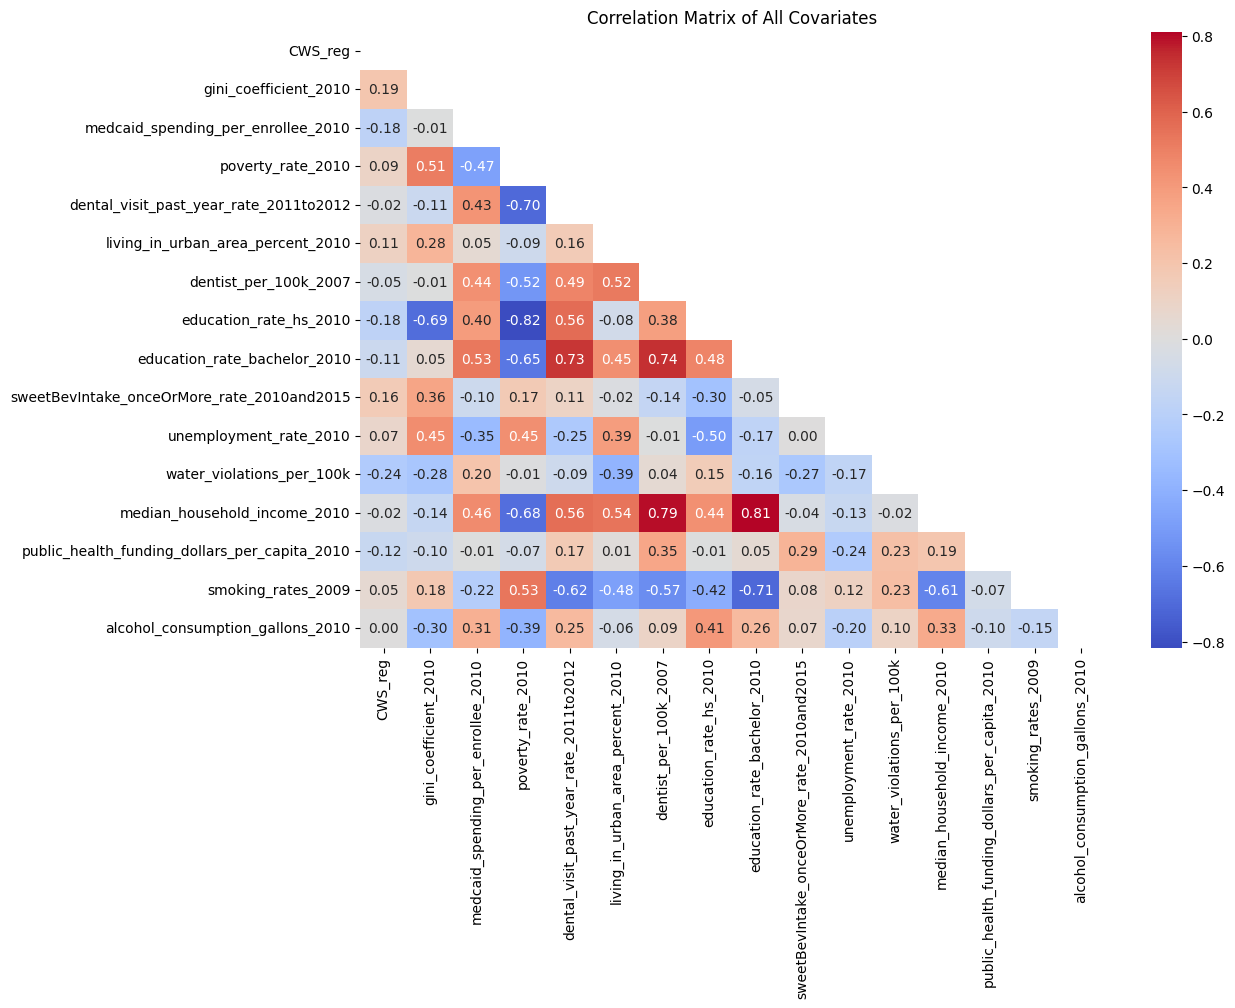

In [ ]:
covariates = pd.read_csv("/work/Causal Inference/all_covariates.csv")
covariates = covariates.drop(columns=["State"])
correlation_matrix = covariates.corr()

# block out repeating upper triangle of values
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# plot heatmap with mask
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", mask=mask)
plt.title("Correlation Matrix of All Covariates")
plt.show()

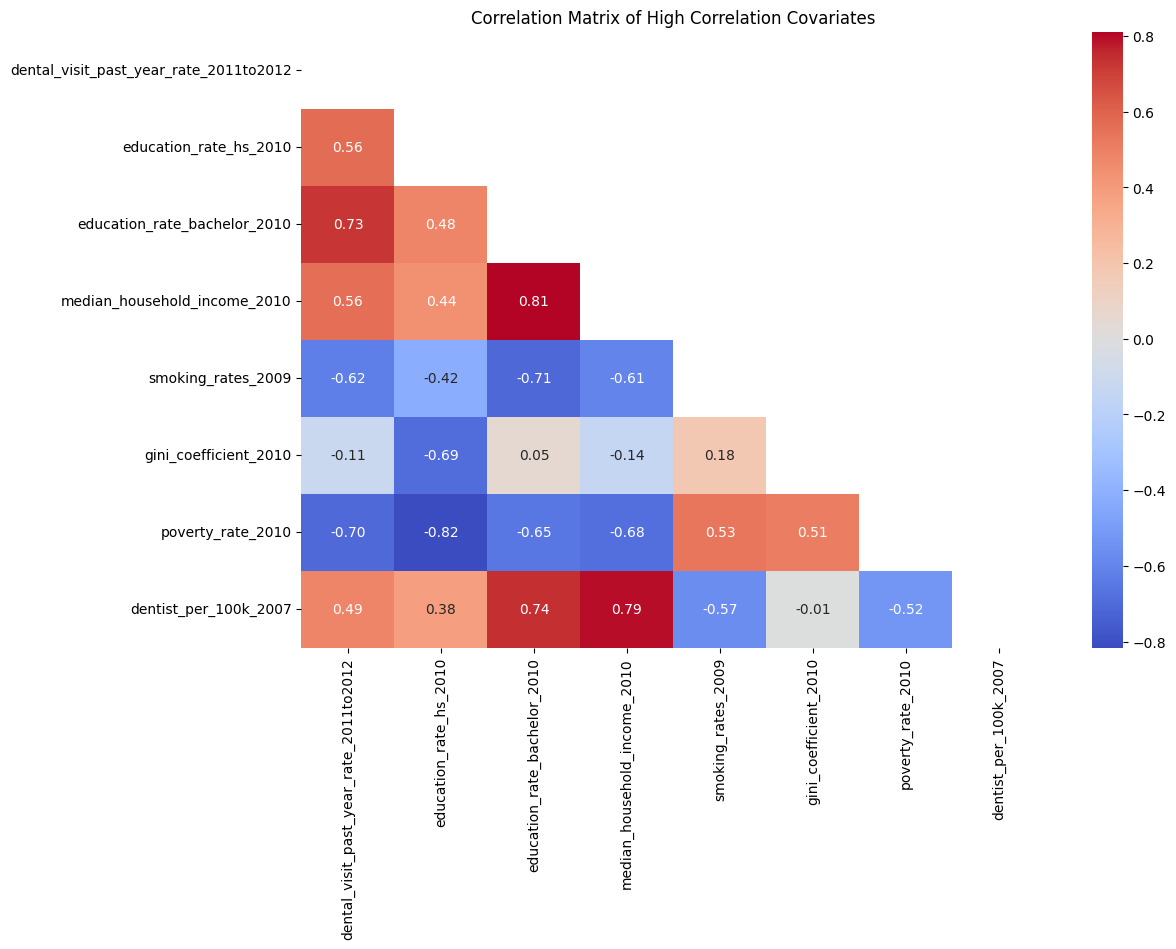

In [ ]:
covariates = pd.read_csv("/work/Causal Inference/all_covariates.csv")
# select high correlation covariates
covariates = covariates[["dental_visit_past_year_rate_2011to2012", "education_rate_hs_2010", "education_rate_bachelor_2010", 
    "median_household_income_2010", "smoking_rates_2009", "gini_coefficient_2010", "poverty_rate_2010", "dentist_per_100k_2007"]]
correlation_matrix = covariates.corr()

# block out repeating upper triangle of values
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# plot heatmap with the mask
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", mask=mask)
plt.title("Correlation Matrix of High Correlation Covariates")
plt.show()

In [ ]:
from scipy.stats import chi2_contingency


df = pd.read_csv("/work/Causal Inference/all_covariates.csv")

covariates = ["gini_coefficient_2010", "medcaid_spending_per_enrollee_2010", "poverty_rate_2010",
            "dental_visit_past_year_rate_2011to2012", "living_in_urban_area_percent_2010",
            "dentist_per_100k_2007", "education_rate_hs_2010", "education_rate_bachelor_2010",
            "sweetBevIntake_onceOrMore_rate_2010and2015", "unemployment_rate_2010",
            "water_violations_per_100k", "median_household_income_2010",
            "public_health_funding_dollars_per_capita_2010", "smoking_rates_2009",
            "alcohol_consumption_gallons_2010"]

target = "CWS_reg"

# calculate chi-squared value for each feature
chi2_scores = {}
for covariate in covariates:
    contingency_table = pd.crosstab(df[covariate], df[target])
    chi2, _, _, _ = chi2_contingency(contingency_table)
    chi2_scores[covariate] = chi2

# display chi-squared values
print("Chi-squared scores for each covariate:")
for feature, score in chi2_scores.items():
    print(f"{feature}: {score}")


Chi-squared scores for each covariate:
gini_coefficient_2010: 7.974457974457974
medcaid_spending_per_enrollee_2010: 49.99999999999999
poverty_rate_2010: 41.337491337491336
dental_visit_past_year_rate_2011to2012: 49.99999999999999
living_in_urban_area_percent_2010: 49.999999999999986
dentist_per_100k_2007: 49.99999999999999
education_rate_hs_2010: 39.6049896049896
education_rate_bachelor_2010: 44.80249480249479
sweetBevIntake_onceOrMore_rate_2010and2015: 41.33749133749132
unemployment_rate_2010: 38.73873873873873
water_violations_per_100k: 49.99999999999999
median_household_income_2010: 49.999999999999986
public_health_funding_dollars_per_capita_2010: 37.006237006236994
smoking_rates_2009: 34.4074844074844
alcohol_consumption_gallons_2010: 41.337491337491336


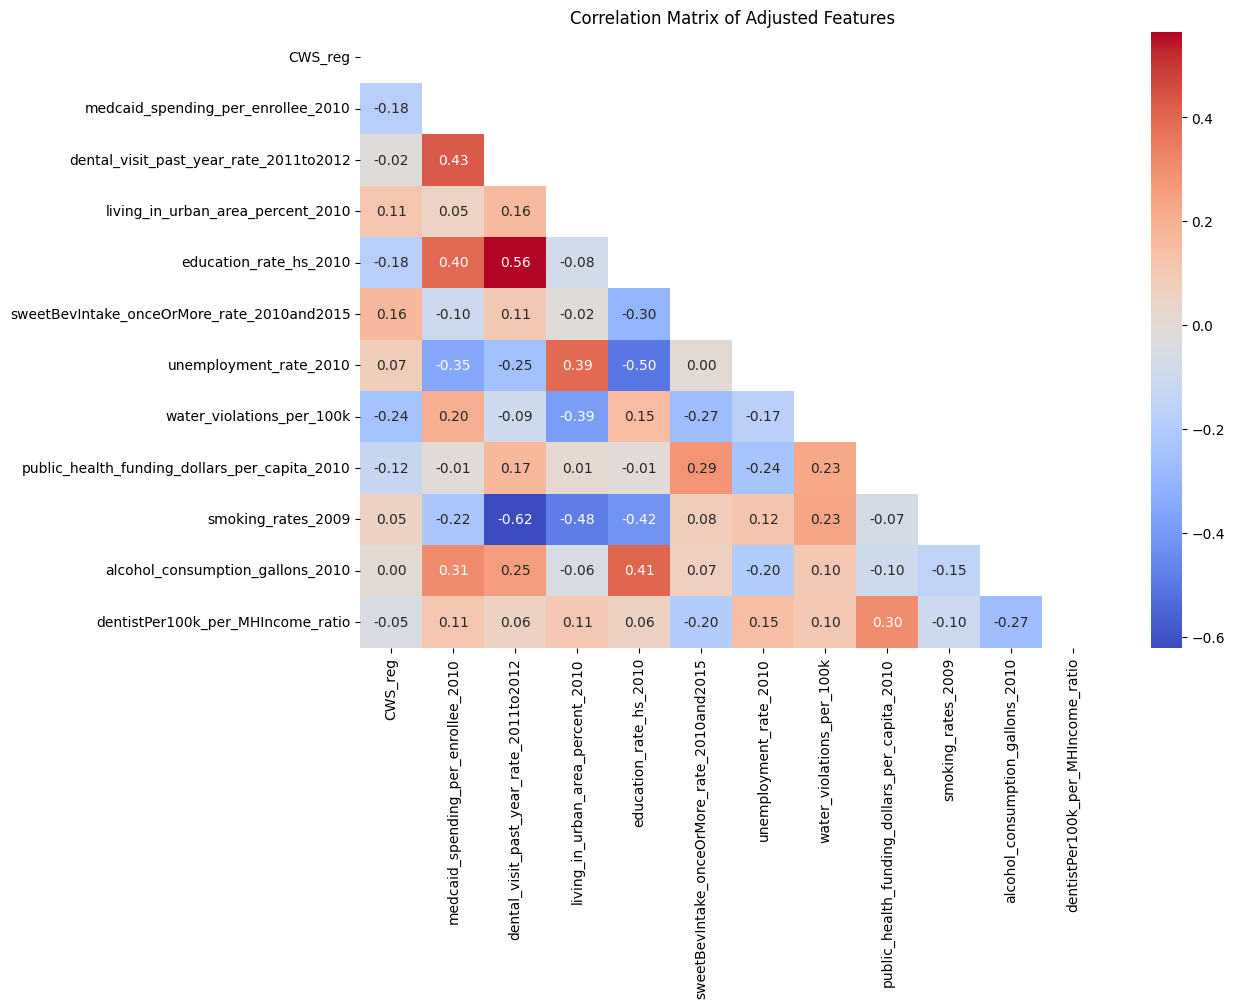

In [ ]:
# use adjusted covariates after feature selection and transformation
covariates = pd.read_csv("/work/Causal Inference/adjusted_covariates.csv")
covariates = covariates.drop(columns=["State"])
correlation_matrix = covariates.corr()

# block out repeating upper triangle of values
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# plot heatmap with the mask
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", mask=mask)
plt.title("Correlation Matrix of Adjusted Features")
plt.show()

# Causal Inference

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


df = pd.read_csv("/work/Causal Inference/adjusted_covariates.csv")

features = [
    "medcaid_spending_per_enrollee_2010",
    "dental_visit_past_year_rate_2011to2012",
    "living_in_urban_area_percent_2010",
    "education_rate_hs_2010",
    "sweetBevIntake_onceOrMore_rate_2010and2015",
    "unemployment_rate_2010",
    "water_violations_per_100k",
    "public_health_funding_dollars_per_capita_2010",
    "smoking_rates_2009",
    "alcohol_consumption_gallons_2010",
    "dentistPer100k_per_MHIncome_ratio"
]

target = "CWS_reg"

# split data into features and target variable
X = df[features]
y = df[target]

# scale the features, mean of 0, sd of 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



threshold = 0.7
bad_model_count = 0
# number of cross-validation runs (different train/test split)
n_runs = 20
bad_rate_per_run = []

for run in range(n_runs):
    # split data into train/test sets with pseudorandom state based on run iteration
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=run)



    logistic_models = []
    # lists to store propensity scores from each model for training and test sets
    train_propensity_scores = []
    test_propensity_scores = []

    # number of models per run
    n_models = 5000
    bad_per_run = 0
    # train logistic regression models with boostrapped aggregation
    for i in range(n_models):
        # create bootstrap sample indices
        bootstrap_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
        
        # create bootstrap sample
        X_bootstrap = X_train[bootstrap_indices]
        y_bootstrap = y_train.iloc[bootstrap_indices]
        
        # don't train model if y_bootstrap only has one type of valuue
        if len(np.unique(y_bootstrap)) != 1:
            # train logistic regression model
            log_reg = LogisticRegression()
            log_reg.fit(X_bootstrap, y_bootstrap)
            
            accuracy = log_reg.score(X_test, y_test)
            
            # if the model performs well, store it and its propensity scores
            if accuracy >= threshold:
                logistic_models.append(log_reg)
                train_propensity_scores.append(log_reg.predict_proba(X_train)[:, 1])
                test_propensity_scores.append(log_reg.predict_proba(X_test)[:, 1])
            else:
                bad_model_count += 1
                bad_per_run += 1
            
    bad_rate_per_run.append(bad_per_run/n_models)

    

# average propensity scores from all models for training and test sets
avg_train_propensity_scores = np.mean(train_propensity_scores, axis=0)
avg_test_propensity_scores = np.mean(test_propensity_scores, axis=0)

# concatenate training and test sets
X_train_df = pd.DataFrame(X_train, columns=features)
X_test_df = pd.DataFrame(X_test, columns=features)
X_concatenated = pd.concat([X_train_df, X_test_df], axis=0)
X_concatenated["State"] = pd.concat([df.iloc[y_train.index]["State"], df.iloc[y_test.index]["State"]], axis=0).values

# add average propensity scores to the concatenated dataset
X_concatenated["Avg_Propensity_Score"] = np.concatenate([avg_train_propensity_scores, avg_test_propensity_scores])

merged_df = df.merge(X_concatenated[["State", "Avg_Propensity_Score"]], on="State")
existing_column = merged_df.pop("Avg_Propensity_Score")  

merged_df.insert(2, "Avg_Propensity_Score", existing_column)

bad_rate_overall = bad_model_count/(n_models*n_runs)

print(f"Bad model rate overall: {bad_rate_overall}")

print(f"# of Good models: {n_models*n_runs-bad_model_count}")

print(f"Bad model rate per run: {bad_rate_per_run}")

print(merged_df)
# merged_df.to_csv("/work/Causal Inference/With Propensity Scores.csv", index=False)

Bad model rate overall: 0.47533
# of Good models: 52467
Bad model rate per run: [0.7464, 0.6916, 0.3524, 0.7794, 0.8978, 0.7262, 0.9268, 0.3444, 0.198, 0.2462, 0.33, 0.6266, 0.5996, 0.3954, 0.1628, 0.1596, 0.6744, 0.3452, 0.1938, 0.11]
             State  CWS_reg  Avg_Propensity_Score  \
0          Alabama        0              0.300691   
1           Alaska        0              0.003141   
2          Arizona        0              0.390777   
3         Arkansas        1              0.473744   
4       California        1              0.393611   
5         Colorado        0              0.220224   
6      Connecticut        1              0.371938   
7         Delaware        1              0.472131   
8          Florida        0              0.390088   
9          Georgia        1              0.534265   
10          Hawaii        0              0.195183   
11           Idaho        0              0.063917   
12        Illinois        1              0.388828   
13         Indiana    

In [ ]:
bad_rates_1k_model = [0.759, 0.694, 0.338, 0.776, 0.91, 0.709, 0.921, 0.333, 0.207, 0.256, 0.353, 0.667, 0.61, 0.405, 0.155, 0.163, 0.701, 0.348, 0.195, 0.119]
bad_rates_5k_model = [0.7442, 0.6806, 0.3546, 0.776, 0.8974, 0.7256, 0.9208, 0.3524, 0.1968, 0.2354, 0.341, 0.6328, 0.6004, 0.3834, 0.1634, 0.1498, 0.6662, 0.3578, 0.1908, 0.108]

abs_diff = np.abs(np.array(bad_rates_1k_model) - np.array(bad_rates_5k_model))
avg_abs_diff = np.mean(abs_diff)

print("Comparing bad model rates per run between 1k models per run and 5k models per run")
print(f"Absolute difference per run: {abs_diff}")
print(f"Average absolute difference of all runs: {avg_abs_diff}")

Comparing bad model rates per run between 1k models per run and 5k models per run
Absolute difference per run: [0.0148 0.0134 0.0166 0.     0.0126 0.0166 0.0002 0.0194 0.0102 0.0206
 0.012  0.0342 0.0096 0.0216 0.0084 0.0132 0.0348 0.0098 0.0042 0.011 ]
Average absolute difference of all runs: 0.014160000000000006


In [ ]:
# merge propensity scores + features with dental outcomes
df1 = pd.read_csv("/work/Causal Inference/With Propensity Scores.csv")
df2 = pd.read_csv("/work/Causal Inference/No tooth loss ages 18-64 age-adjusted prevalence.csv")

merged_df = pd.merge(df1, df2, on='State')

merged_df.to_csv("/work/Causal Inference/Propensity Score + Outcomes.csv", index=False)

In [ ]:
import pandas as pd

data = pd.read_csv("/work/Causal Inference/Propensity Score + Outcomes.csv")

# sort data based on treatment
treated = data[data["CWS_reg"] == 1]
untreated = data[data["CWS_reg"] == 0]

# use IPW ATE calculation from lab8 
ate_2014 = ((treated["2014_noToothLoss18to64"] / treated["Avg_Propensity_Score"]).sum() / len(data)) - \
           ((untreated["2014_noToothLoss18to64"] / (1 - untreated["Avg_Propensity_Score"])).sum() / len(data))

ate_2016 = ((treated["2016_noToothLoss18to64"] / treated["Avg_Propensity_Score"]).sum() / len(data)) - \
           ((untreated["2016_noToothLoss18to64"] / (1 - untreated["Avg_Propensity_Score"])).sum() / len(data))

ate_2018 = ((treated["2018_noToothLoss18to64"] / treated["Avg_Propensity_Score"]).sum() / len(data)) - \
           ((untreated["2018_noToothLoss18to64"] / (1 - untreated["Avg_Propensity_Score"])).sum() / len(data))

ate_2020 = ((treated["2020_noToothLoss18to64"] / treated["Avg_Propensity_Score"]).sum() / len(data)) - \
           ((untreated["2020_noToothLoss18to64"] / (1 - untreated["Avg_Propensity_Score"])).sum() / len(data))


results = pd.DataFrame({
    "Year": [2014, 2016, 2018, 2020],
    "IPW_estimate_ATE": [ate_2014, ate_2016, ate_2018, ate_2020]
})

print("IPW ATE estimate:")
print(results)

IPW ATE estimate:
   Year  IPW_estimate_ATE
0  2014        -14.247559
1  2016        -13.720031
2  2018        -15.267385
3  2020        -15.379759


In [ ]:
from causalinference import CausalModel

data = pd.read_csv("/work/Causal Inference/Propensity Score + Outcomes.csv")

# extract the outcome variables, treatment variable, and covariates as numpy arrays
Y_2020 = data["2020_noToothLoss18to64"].values
Y_2018 = data["2018_noToothLoss18to64"].values
Y_2016 = data["2016_noToothLoss18to64"].values
Y_2014 = data["2014_noToothLoss18to64"].values
D = data["CWS_reg"].values
X = data[["medcaid_spending_per_enrollee_2010", "dental_visit_past_year_rate_2011to2012", 
          "living_in_urban_area_percent_2010", "education_rate_hs_2010", 
          "sweetBevIntake_onceOrMore_rate_2010and2015", "unemployment_rate_2010", 
          "water_violations_per_100k", "public_health_funding_dollars_per_capita_2010", 
          "smoking_rates_2009", "alcohol_consumption_gallons_2010", 
          "dentistPer100k_per_MHIncome_ratio"]].values

# create a CausalModel object for each outcome year
cm_2020 = CausalModel(Y=Y_2020, D=D, X=X)
cm_2018 = CausalModel(Y=Y_2018, D=D, X=X)
cm_2016 = CausalModel(Y=Y_2016, D=D, X=X)
cm_2014 = CausalModel(Y=Y_2014, D=D, X=X)

# fit the models
cm_2020.est_via_ols(adj=1)
cm_2018.est_via_ols(adj=1)
cm_2016.est_via_ols(adj=1)
cm_2014.est_via_ols(adj=1)

# estimate the treatment effects using the OLS estimator
te_2020 = cm_2020.estimates["ols"]
te_2018 = cm_2018.estimates["ols"]
te_2016 = cm_2016.estimates["ols"]
te_2014 = cm_2014.estimates["ols"]

# print the estimated treatment effects
print("Augmented IPW ATE estimate:")
print("Average Treatment Effect (ATE) for 2020:", te_2020)
print("Average Treatment Effect (ATE) for 2018:", te_2018)
print("Average Treatment Effect (ATE) for 2016:", te_2016)
print("Average Treatment Effect (ATE) for 2014:", te_2014)


Augmented IPW ATE estimate:
Average Treatment Effect (ATE) for 2020: 
Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.056      0.533      0.105      0.917     -0.989      1.100

Average Treatment Effect (ATE) for 2018: 
Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.017      0.736     -0.023      0.982     -1.460      1.427

Average Treatment Effect (ATE) for 2016: 
Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.074      0.650      1.653      0.098     -0.200      2.348

Average Treatme

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=02bc2dab-94cb-4b89-94f3-d2a5d64fe0b1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>